In [1]:
import sys,os, math, glob, time  
from builtins import zip  
sys.path.append('/data/fragosta/work/lsst/sims_maf_contrib-master/')  
import numpy as np
import pandas as pd  
import matplotlib.pyplot as plt  
import seaborn as sns  
from scipy.stats import norm, uniform  
from sklearn.neighbors import KernelDensity  
import lsst.sims.maf.slicers as slicers  
import lsst.sims.maf.metrics as metrics  
import lsst.sims.maf.metricBundles as metricBundles  
import lsst.sims.maf.db as db  
import lsst.sims.maf.plots as plots  
from lsst.sims.utils import equatorialFromGalactic, galacticFromEquatorial  
from lsst.sims.maf.metrics import BaseMetric, starDensity   
from lsst.sims.maf.utils import m52snr 
from opsimUtils import *  
from astropy.io import fits   
from sklearn.utils import shuffle
import sklearn.mixture as GMM  
import astrometry_metrics
%matplotlib inline 

In [2]:
your_username = 'fragosta'
if your_username == '': # do NOT put your username here, put it in the cell at the top of the notebook. 
         raise Exception('Please provide your username!  See the top of the notebook.') 

dbDir = '/home/idies/workspace/lsst_cadence/FBS_1.5/' 
outDir = '/home/idies/workspace/Storage/{}/persistent/MAFOutput/MetricData/Astrometry_loc'.format(your_username) 

if not os.path.exists(os.path.abspath(outDir)): 
     os.mkdir(os.path.abspath(outDir)) 
dbRuns = show_opsims(dbDir) 
opSimDbs, resultDbs = connect_dbs(dbDir, outDir)

In [3]:
U=np.arange(-100,100,5) 
W=np.arange(-100,100,5) 
V=np.arange(-100,100,5) 
def readfile( filename='', colsname=['']): 
    if 'csv' in filename: 
        #print('reading {}'.format(filename)) 
        data = pd.read_csv(filename, header=0, names = colsname ) 
    elif 'fits' in filename: 
        #print('reading {}'.format(filename)) 
        hdul = fits.open(filename) 
        data = hdul[1].data 
    elif ['txt', 'dat'] in filename: 
        #print('reading {}'.format(filename)) 
        data = {k:[] for k in colsname} 
        f = open(filename) 
        righe = f.readlines() 
        for line in righe: 
            line.split() 
            for i, k in enumerate(colsname): 
                data[k].append(float(line[i]))                 
    elif 'json'in filename: 
        print('not implemented to read .json extention') 
    return data 

In [656]:
names = ['ra', 'dec', 'seeing']    
npoint = 1  #  Note, we are going to loop over each object, so try not to make this a crazy huge number. 
transienobj = np.zeros(npoint, dtype=list(zip(names, [float]*len(names))))
# to random selection of position in the sky
l = 150.09671833  # np.random.rand(npoint)*2+30.
b = 2.18284020 # np.random.rand(npoint)*1+1.
#transienobj['ra'], transienobj['dec'] = equatorialFromGalactic(l,b) 
transienobj['ra'], transienobj['dec'] = l, b
#transObjects['seeing'] = np.random.rand(npo

In [189]:
transienobj[6]

(31.96253877, 1.05857857, 0.)

In [4]:
filename = 'data.csv' 
colsname=['RA', 'DEC','g','g-r','Hg','PM','deltaX'] 
data = readfile(filename, colsname) 
#transienobj= pd.DataFrame({'ra':data['RA'], 'dec':data['DEC']}) 
metric1 = astrometry_metrics.LSPMmetric(f='g',m5Col='fiveSigmaDepth', mjdCol='observationStartMJD', seeingCol='seeingFwhmGeom',percentiles=[0.5,99.0,50],surveyduration = 2,dataout=False) 
metric2 = astrometry_metrics.TransienPM(Mmin=18,Mmax=24,f='g',m5Col='fiveSigmaDepth', mjdCol='observationStartMJD', seeingCol='seeingFwhmGeom',surveyduration=2) 
metric3 = astrometry_metrics.confusionmetric(filename='data.csv', colsname=['RA', 'DEC','g','g-r','Hg','PM','deltaX'],snr_lim=5,mode='distance', surveyduration = 2, MagIterLim=[2,3,1],m5Col='fiveSigmaDepth', mjdCol='observationStartMJD',filterCol='filter', seeingCol='seeingFwhmGeom',dataout=False) 
star = starDensity.StarDensityMetric()
#slicer3 = slicers.UserPointsSlicer(transienobj['ra'], transienobj['dec']) 
sqlconstraint ='note not like  "DD%" ' 
slicer = slicers.HealpixSlicer(nside=16) 
metricSky1 = metricBundles.MetricBundle(metric1,slicer,sqlconstraint) 
metricSky2 = metricBundles.MetricBundle(metric2,slicer,sqlconstraint) 
metricSky3 = metricBundles.MetricBundle(metric3,slicer,sqlconstraint)
starDens = metricBundles.MetricBundle(star,slicer,sqlconstraint)
#bundleDict={'transient':metricSky2, 'confusion': metricSky3} 
bundleDict={'like':metricSky1,'star':starDens}

Healpix slicer using NSIDE=16, approximate resolution 219.871130 arcminutes


In [72]:
metric_runs=['twilight_neo_mod2_v1.5_10yrs','dcr_nham2_ugr_v1.5_10yrs','baseline_v1.5_10yrs','wfd_depth_scale0.95_noddf_v1.5_10yrs']

In [5]:
metricDataPath = '/home/idies/workspace/Storage/{}/persistent/MAFOutput/MetricData/Astrometry_loc'.format(your_username)

# below I am only going to run metrics on the first five opsims
for i, run in enumerate(dbRuns):
    print('##############\n')
    print('N_{}, {} is running\n'.format(i+1,run))
    print('##############\n')
    start_time = time.time()
    # must set run name for each opSim to store metric data into
    # separate files
    metricSky1.setRunName(run)
    starDens.setRunName(run)
    #metricSky2.setRunName(run)
    #metricSky3.setRunName(run)
    group = metricBundles.MetricBundleGroup(bundleDict, opSimDbs[run], metricDataPath, resultDbs[run])
    group.runAll()
    print( '--- {:.2f} minutes ---\n'.format((time.time() - start_time)/60))
    print('####################\n')

##############

N_1, dcr_nham1_ugri_v1.5_10yrs is running

##############

Querying database SummaryAllProps with constraint note not like  "DD%"  for columns ['observationStartMJD', 'seeingFwhmGeom', 'fieldDec', 'fiveSigmaDepth', 'filter', 'fieldRA', 'night']
Found 2121814 visits
Running:  ['like', 'star']


/home/idies/lsst/stack/miniconda3-4.7.10-4d7b902/Linux64/sims_maf/2.13.0.sims-24-gbe21ed04+1/python/lsst/sims/maf/slicers/baseSpatialSlicer.py:107: UserWarning: Warning:  Loading maps but cache on.Should probably set useCache=False in slicer.
  warnings.warn('Warning:  Loading maps but cache on.'


Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
--- 1.16 minutes ---

####################

##############

N_2, rolling_mod6_sdf_0.20_v1.5_10yrs is running

##############

Querying database SummaryAllProps with constraint note not like  "DD%"  for columns ['observationStartMJD', 'seeingFwhmGeom', 'fieldDec', 'fiveSigmaDepth', 'filter', 'fieldRA', 'night']
Found 2134426 visits
Running:  ['like', 'star']


/home/idies/lsst/stack/miniconda3-4.7.10-4d7b902/Linux64/sims_maf/2.13.0.sims-24-gbe21ed04+1/python/lsst/sims/maf/slicers/baseSpatialSlicer.py:107: UserWarning: Warning:  Loading maps but cache on.Should probably set useCache=False in slicer.
  warnings.warn('Warning:  Loading maps but cache on.'


Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
--- 1.10 minutes ---

####################

##############

N_3, wfd_depth_scale0.95_noddf_v1.5_10yrs is running

##############

Querying database SummaryAllProps with constraint note not like  "DD%"  for columns ['observationStartMJD', 'seeingFwhmGeom', 'fieldDec', 'fiveSigmaDepth', 'filter', 'fieldRA', 'night']
Found 2225655 visits
Running:  ['like', 'star']


/home/idies/lsst/stack/miniconda3-4.7.10-4d7b902/Linux64/sims_maf/2.13.0.sims-24-gbe21ed04+1/python/lsst/sims/maf/slicers/baseSpatialSlicer.py:107: UserWarning: Warning:  Loading maps but cache on.Should probably set useCache=False in slicer.
  warnings.warn('Warning:  Loading maps but cache on.'


Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
--- 1.14 minutes ---

####################

##############

N_4, u60_v1.5_10yrs is running

##############

Querying database SummaryAllProps with constraint note not like  "DD%"  for columns ['observationStartMJD', 'seeingFwhmGeom', 'fieldDec', 'fiveSigmaDepth', 'filter', 'fieldRA', 'night']
Found 1999346 visits
Running:  ['like', 'star']


/home/idies/lsst/stack/miniconda3-4.7.10-4d7b902/Linux64/sims_maf/2.13.0.sims-24-gbe21ed04+1/python/lsst/sims/maf/slicers/baseSpatialSlicer.py:107: UserWarning: Warning:  Loading maps but cache on.Should probably set useCache=False in slicer.
  warnings.warn('Warning:  Loading maps but cache on.'


Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
--- 1.11 minutes ---

####################

##############

N_5, footprint_stuck_rollingv1.5_10yrs is running

##############

Querying database SummaryAllProps with constraint note not like  "DD%"  for columns ['observationStartMJD', 'seeingFwhmGeom', 'fieldDec', 'fiveSigmaDepth', 'filter', 'fieldRA', 'night']
Found 2132915 visits
Running:  ['like', 'star']


/home/idies/lsst/stack/miniconda3-4.7.10-4d7b902/Linux64/sims_maf/2.13.0.sims-24-gbe21ed04+1/python/lsst/sims/maf/slicers/baseSpatialSlicer.py:107: UserWarning: Warning:  Loading maps but cache on.Should probably set useCache=False in slicer.
  warnings.warn('Warning:  Loading maps but cache on.'


Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
--- 1.12 minutes ---

####################

##############

N_6, filterdist_indx4_v1.5_10yrs is running

##############

Querying database SummaryAllProps with constraint note not like  "DD%"  for columns ['observationStartMJD', 'seeingFwhmGeom', 'fieldDec', 'fiveSigmaDepth', 'filter', 'fieldRA', 'night']
Found 2221366 visits
Running:  ['like', 'star']


/home/idies/lsst/stack/miniconda3-4.7.10-4d7b902/Linux64/sims_maf/2.13.0.sims-24-gbe21ed04+1/python/lsst/sims/maf/slicers/baseSpatialSlicer.py:107: UserWarning: Warning:  Loading maps but cache on.Should probably set useCache=False in slicer.
  warnings.warn('Warning:  Loading maps but cache on.'


Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
--- 1.02 minutes ---

####################

##############

N_7, wfd_depth_scale0.70_noddf_v1.5_10yrs is running

##############

Querying database SummaryAllProps with constraint note not like  "DD%"  for columns ['observationStartMJD', 'seeingFwhmGeom', 'fieldDec', 'fiveSigmaDepth', 'filter', 'fieldRA', 'night']
Found 2227429 visits
Running:  ['like', 'star']


/home/idies/lsst/stack/miniconda3-4.7.10-4d7b902/Linux64/sims_maf/2.13.0.sims-24-gbe21ed04+1/python/lsst/sims/maf/slicers/baseSpatialSlicer.py:107: UserWarning: Warning:  Loading maps but cache on.Should probably set useCache=False in slicer.
  warnings.warn('Warning:  Loading maps but cache on.'


Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
--- 1.12 minutes ---

####################

##############

N_8, daily_ddf_v1.5_10yrs is running

##############

Querying database SummaryAllProps with constraint note not like  "DD%"  for columns ['observationStartMJD', 'seeingFwhmGeom', 'fieldDec', 'fiveSigmaDepth', 'filter', 'fieldRA', 'night']
Found 2022891 visits
Running:  ['like', 'star']


/home/idies/lsst/stack/miniconda3-4.7.10-4d7b902/Linux64/sims_maf/2.13.0.sims-24-gbe21ed04+1/python/lsst/sims/maf/slicers/baseSpatialSlicer.py:107: UserWarning: Warning:  Loading maps but cache on.Should probably set useCache=False in slicer.
  warnings.warn('Warning:  Loading maps but cache on.'


Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
--- 1.07 minutes ---

####################

##############

N_9, alt_roll_mod2_dust_sdf_0.20_v1.5_10yrs is running

##############

Querying database SummaryAllProps with constraint note not like  "DD%"  for columns ['observationStartMJD', 'seeingFwhmGeom', 'fieldDec', 'fiveSigmaDepth', 'filter', 'fieldRA', 'night']
Found 2134566 visits
Running:  ['like', 'star']


/home/idies/lsst/stack/miniconda3-4.7.10-4d7b902/Linux64/sims_maf/2.13.0.sims-24-gbe21ed04+1/python/lsst/sims/maf/slicers/baseSpatialSlicer.py:107: UserWarning: Warning:  Loading maps but cache on.Should probably set useCache=False in slicer.
  warnings.warn('Warning:  Loading maps but cache on.'


Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
--- 1.18 minutes ---

####################

##############

N_10, goodseeing_gz_v1.5_10yrs is running

##############

Querying database SummaryAllProps with constraint note not like  "DD%"  for columns ['observationStartMJD', 'seeingFwhmGeom', 'fieldDec', 'fiveSigmaDepth', 'filter', 'fieldRA', 'night']
Found 2120407 visits
Running:  ['like', 'star']


/home/idies/lsst/stack/miniconda3-4.7.10-4d7b902/Linux64/sims_maf/2.13.0.sims-24-gbe21ed04+1/python/lsst/sims/maf/slicers/baseSpatialSlicer.py:107: UserWarning: Warning:  Loading maps but cache on.Should probably set useCache=False in slicer.
  warnings.warn('Warning:  Loading maps but cache on.'


Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
--- 1.08 minutes ---

####################

##############

N_11, filterdist_indx1_v1.5_10yrs is running

##############

Querying database SummaryAllProps with constraint note not like  "DD%"  for columns ['observationStartMJD', 'seeingFwhmGeom', 'fieldDec', 'fiveSigmaDepth', 'filter', 'fieldRA', 'night']
Found 2220872 visits
Running:  ['like', 'star']


/home/idies/lsst/stack/miniconda3-4.7.10-4d7b902/Linux64/sims_maf/2.13.0.sims-24-gbe21ed04+1/python/lsst/sims/maf/slicers/baseSpatialSlicer.py:107: UserWarning: Warning:  Loading maps but cache on.Should probably set useCache=False in slicer.
  warnings.warn('Warning:  Loading maps but cache on.'


Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
--- 1.00 minutes ---

####################

##############

N_12, footprint_standard_goalsv1.5_10yrs is running

##############

Querying database SummaryAllProps with constraint note not like  "DD%"  for columns ['observationStartMJD', 'seeingFwhmGeom', 'fieldDec', 'fiveSigmaDepth', 'filter', 'fieldRA', 'night']
Found 2122800 visits
Running:  ['like', 'star']


/home/idies/lsst/stack/miniconda3-4.7.10-4d7b902/Linux64/sims_maf/2.13.0.sims-24-gbe21ed04+1/python/lsst/sims/maf/slicers/baseSpatialSlicer.py:107: UserWarning: Warning:  Loading maps but cache on.Should probably set useCache=False in slicer.
  warnings.warn('Warning:  Loading maps but cache on.'


Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
--- 1.10 minutes ---

####################

##############

N_13, footprint_big_sky_dustv1.5_10yrs is running

##############

Querying database SummaryAllProps with constraint note not like  "DD%"  for columns ['observationStartMJD', 'seeingFwhmGeom', 'fieldDec', 'fiveSigmaDepth', 'filter', 'fieldRA', 'night']
Found 2125213 visits
Running:  ['like', 'star']


/home/idies/lsst/stack/miniconda3-4.7.10-4d7b902/Linux64/sims_maf/2.13.0.sims-24-gbe21ed04+1/python/lsst/sims/maf/slicers/baseSpatialSlicer.py:107: UserWarning: Warning:  Loading maps but cache on.Should probably set useCache=False in slicer.
  warnings.warn('Warning:  Loading maps but cache on.'


Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
--- 1.09 minutes ---

####################

##############

N_14, footprint_bluer_footprintv1.5_10yrs is running

##############

Querying database SummaryAllProps with constraint note not like  "DD%"  for columns ['observationStartMJD', 'seeingFwhmGeom', 'fieldDec', 'fiveSigmaDepth', 'filter', 'fieldRA', 'night']
Found 2121414 visits
Running:  ['like', 'star']


/home/idies/lsst/stack/miniconda3-4.7.10-4d7b902/Linux64/sims_maf/2.13.0.sims-24-gbe21ed04+1/python/lsst/sims/maf/slicers/baseSpatialSlicer.py:107: UserWarning: Warning:  Loading maps but cache on.Should probably set useCache=False in slicer.
  warnings.warn('Warning:  Loading maps but cache on.'


Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
--- 1.11 minutes ---

####################

##############

N_15, twilight_neo_mod4_v1.5_10yrs is running

##############

Querying database SummaryAllProps with constraint note not like  "DD%"  for columns ['observationStartMJD', 'seeingFwhmGeom', 'fieldDec', 'fiveSigmaDepth', 'filter', 'fieldRA', 'night']
Found 2349955 visits
Running:  ['like', 'star']


/home/idies/lsst/stack/miniconda3-4.7.10-4d7b902/Linux64/sims_maf/2.13.0.sims-24-gbe21ed04+1/python/lsst/sims/maf/slicers/baseSpatialSlicer.py:107: UserWarning: Warning:  Loading maps but cache on.Should probably set useCache=False in slicer.
  warnings.warn('Warning:  Loading maps but cache on.'


Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
--- 1.16 minutes ---

####################

##############

N_16, goodseeing_gi_v1.5_10yrs is running

##############

Querying database SummaryAllProps with constraint note not like  "DD%"  for columns ['observationStartMJD', 'seeingFwhmGeom', 'fieldDec', 'fiveSigmaDepth', 'filter', 'fieldRA', 'night']
Found 2121449 visits
Running:  ['like', 'star']


/home/idies/lsst/stack/miniconda3-4.7.10-4d7b902/Linux64/sims_maf/2.13.0.sims-24-gbe21ed04+1/python/lsst/sims/maf/slicers/baseSpatialSlicer.py:107: UserWarning: Warning:  Loading maps but cache on.Should probably set useCache=False in slicer.
  warnings.warn('Warning:  Loading maps but cache on.'


Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
--- 1.11 minutes ---

####################

##############

N_17, footprint_big_wfdv1.5_10yrs is running

##############

Querying database SummaryAllProps with constraint note not like  "DD%"  for columns ['observationStartMJD', 'seeingFwhmGeom', 'fieldDec', 'fiveSigmaDepth', 'filter', 'fieldRA', 'night']
Found 2128853 visits
Running:  ['like', 'star']


/home/idies/lsst/stack/miniconda3-4.7.10-4d7b902/Linux64/sims_maf/2.13.0.sims-24-gbe21ed04+1/python/lsst/sims/maf/slicers/baseSpatialSlicer.py:107: UserWarning: Warning:  Loading maps but cache on.Should probably set useCache=False in slicer.
  warnings.warn('Warning:  Loading maps but cache on.'


Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
--- 1.23 minutes ---

####################

##############

N_18, dcr_nham2_ugr_v1.5_10yrs is running

##############

Querying database SummaryAllProps with constraint note not like  "DD%"  for columns ['observationStartMJD', 'seeingFwhmGeom', 'fieldDec', 'fiveSigmaDepth', 'filter', 'fieldRA', 'night']
Found 2123062 visits
Running:  ['like', 'star']


/home/idies/lsst/stack/miniconda3-4.7.10-4d7b902/Linux64/sims_maf/2.13.0.sims-24-gbe21ed04+1/python/lsst/sims/maf/slicers/baseSpatialSlicer.py:107: UserWarning: Warning:  Loading maps but cache on.Should probably set useCache=False in slicer.
  warnings.warn('Warning:  Loading maps but cache on.'


Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
--- 1.12 minutes ---

####################

##############

N_19, short_exp_5ns_5expt_v1.5_10yrs is running

##############

Querying database SummaryAllProps with constraint note not like  "DD%"  for columns ['observationStartMJD', 'seeingFwhmGeom', 'fieldDec', 'fiveSigmaDepth', 'filter', 'fieldRA', 'night']
Found 2693327 visits
Running:  ['like', 'star']


/home/idies/lsst/stack/miniconda3-4.7.10-4d7b902/Linux64/sims_maf/2.13.0.sims-24-gbe21ed04+1/python/lsst/sims/maf/slicers/baseSpatialSlicer.py:107: UserWarning: Warning:  Loading maps but cache on.Should probably set useCache=False in slicer.
  warnings.warn('Warning:  Loading maps but cache on.'


Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
--- 1.32 minutes ---

####################

##############

N_20, goodseeing_griz_v1.5_10yrs is running

##############

Querying database SummaryAllProps with constraint note not like  "DD%"  for columns ['observationStartMJD', 'seeingFwhmGeom', 'fieldDec', 'fiveSigmaDepth', 'filter', 'fieldRA', 'night']
Found 2118777 visits
Running:  ['like', 'star']


/home/idies/lsst/stack/miniconda3-4.7.10-4d7b902/Linux64/sims_maf/2.13.0.sims-24-gbe21ed04+1/python/lsst/sims/maf/slicers/baseSpatialSlicer.py:107: UserWarning: Warning:  Loading maps but cache on.Should probably set useCache=False in slicer.
  warnings.warn('Warning:  Loading maps but cache on.'


Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
--- 1.11 minutes ---

####################

##############

N_21, twilight_neo_mod1_v1.5_10yrs is running

##############

Querying database SummaryAllProps with constraint note not like  "DD%"  for columns ['observationStartMJD', 'seeingFwhmGeom', 'fieldDec', 'fiveSigmaDepth', 'filter', 'fieldRA', 'night']
Found 3031581 visits
Running:  ['like', 'star']


/home/idies/lsst/stack/miniconda3-4.7.10-4d7b902/Linux64/sims_maf/2.13.0.sims-24-gbe21ed04+1/python/lsst/sims/maf/slicers/baseSpatialSlicer.py:107: UserWarning: Warning:  Loading maps but cache on.Should probably set useCache=False in slicer.
  warnings.warn('Warning:  Loading maps but cache on.'


Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
--- 1.39 minutes ---

####################

##############

N_22, bulges_cadence_bulge_wfd_v1.5_10yrs is running

##############

Querying database SummaryAllProps with constraint note not like  "DD%"  for columns ['observationStartMJD', 'seeingFwhmGeom', 'fieldDec', 'fiveSigmaDepth', 'filter', 'fieldRA', 'night']
Found 2128140 visits
Running:  ['like', 'star']


/home/idies/lsst/stack/miniconda3-4.7.10-4d7b902/Linux64/sims_maf/2.13.0.sims-24-gbe21ed04+1/python/lsst/sims/maf/slicers/baseSpatialSlicer.py:107: UserWarning: Warning:  Loading maps but cache on.Should probably set useCache=False in slicer.
  warnings.warn('Warning:  Loading maps but cache on.'


Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
--- 1.19 minutes ---

####################

##############

N_23, third_obs_pt120v1.5_10yrs is running

##############

Querying database SummaryAllProps with constraint note not like  "DD%"  for columns ['observationStartMJD', 'seeingFwhmGeom', 'fieldDec', 'fiveSigmaDepth', 'filter', 'fieldRA', 'night']
Found 2138160 visits
Running:  ['like', 'star']


/home/idies/lsst/stack/miniconda3-4.7.10-4d7b902/Linux64/sims_maf/2.13.0.sims-24-gbe21ed04+1/python/lsst/sims/maf/slicers/baseSpatialSlicer.py:107: UserWarning: Warning:  Loading maps but cache on.Should probably set useCache=False in slicer.
  warnings.warn('Warning:  Loading maps but cache on.'


Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
--- 1.13 minutes ---

####################

##############

N_24, wfd_depth_scale0.95_v1.5_10yrs is running

##############

Querying database SummaryAllProps with constraint note not like  "DD%"  for columns ['observationStartMJD', 'seeingFwhmGeom', 'fieldDec', 'fiveSigmaDepth', 'filter', 'fieldRA', 'night']
Found 2123075 visits
Running:  ['like', 'star']


/home/idies/lsst/stack/miniconda3-4.7.10-4d7b902/Linux64/sims_maf/2.13.0.sims-24-gbe21ed04+1/python/lsst/sims/maf/slicers/baseSpatialSlicer.py:107: UserWarning: Warning:  Loading maps but cache on.Should probably set useCache=False in slicer.
  warnings.warn('Warning:  Loading maps but cache on.'


Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
--- 1.10 minutes ---

####################

##############

N_25, wfd_depth_scale0.85_noddf_v1.5_10yrs is running

##############

Querying database SummaryAllProps with constraint note not like  "DD%"  for columns ['observationStartMJD', 'seeingFwhmGeom', 'fieldDec', 'fiveSigmaDepth', 'filter', 'fieldRA', 'night']
Found 2226787 visits
Running:  ['like', 'star']


/home/idies/lsst/stack/miniconda3-4.7.10-4d7b902/Linux64/sims_maf/2.13.0.sims-24-gbe21ed04+1/python/lsst/sims/maf/slicers/baseSpatialSlicer.py:107: UserWarning: Warning:  Loading maps but cache on.Should probably set useCache=False in slicer.
  warnings.warn('Warning:  Loading maps but cache on.'


Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
--- 1.13 minutes ---

####################

##############

N_26, footprint_no_gp_northv1.5_10yrs is running

##############

Querying database SummaryAllProps with constraint note not like  "DD%"  for columns ['observationStartMJD', 'seeingFwhmGeom', 'fieldDec', 'fiveSigmaDepth', 'filter', 'fieldRA', 'night']
Found 2122745 visits
Running:  ['like', 'star']


/home/idies/lsst/stack/miniconda3-4.7.10-4d7b902/Linux64/sims_maf/2.13.0.sims-24-gbe21ed04+1/python/lsst/sims/maf/slicers/baseSpatialSlicer.py:107: UserWarning: Warning:  Loading maps but cache on.Should probably set useCache=False in slicer.
  warnings.warn('Warning:  Loading maps but cache on.'


Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
--- 1.10 minutes ---

####################

##############

N_27, footprint_big_skyv1.5_10yrs is running

##############

Querying database SummaryAllProps with constraint note not like  "DD%"  for columns ['observationStartMJD', 'seeingFwhmGeom', 'fieldDec', 'fiveSigmaDepth', 'filter', 'fieldRA', 'night']
Found 2130627 visits
Running:  ['like', 'star']


/home/idies/lsst/stack/miniconda3-4.7.10-4d7b902/Linux64/sims_maf/2.13.0.sims-24-gbe21ed04+1/python/lsst/sims/maf/slicers/baseSpatialSlicer.py:107: UserWarning: Warning:  Loading maps but cache on.Should probably set useCache=False in slicer.
  warnings.warn('Warning:  Loading maps but cache on.'


Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
--- 1.05 minutes ---

####################

##############

N_28, footprint_newBv1.5_10yrs is running

##############

Querying database SummaryAllProps with constraint note not like  "DD%"  for columns ['observationStartMJD', 'seeingFwhmGeom', 'fieldDec', 'fiveSigmaDepth', 'filter', 'fieldRA', 'night']
Found 2130000 visits
Running:  ['like', 'star']


/home/idies/lsst/stack/miniconda3-4.7.10-4d7b902/Linux64/sims_maf/2.13.0.sims-24-gbe21ed04+1/python/lsst/sims/maf/slicers/baseSpatialSlicer.py:107: UserWarning: Warning:  Loading maps but cache on.Should probably set useCache=False in slicer.
  warnings.warn('Warning:  Loading maps but cache on.'


Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
--- 1.18 minutes ---

####################

##############

N_29, baseline_2snaps_v1.5_10yrs is running

##############

Querying database SummaryAllProps with constraint note not like  "DD%"  for columns ['observationStartMJD', 'seeingFwhmGeom', 'fieldDec', 'fiveSigmaDepth', 'filter', 'fieldRA', 'night']
Found 1962757 visits
Running:  ['like', 'star']


/home/idies/lsst/stack/miniconda3-4.7.10-4d7b902/Linux64/sims_maf/2.13.0.sims-24-gbe21ed04+1/python/lsst/sims/maf/slicers/baseSpatialSlicer.py:107: UserWarning: Warning:  Loading maps but cache on.Should probably set useCache=False in slicer.
  warnings.warn('Warning:  Loading maps but cache on.'


Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
--- 1.07 minutes ---

####################

##############

N_30, footprint_big_sky_nouiyv1.5_10yrs is running

##############

Querying database SummaryAllProps with constraint note not like  "DD%"  for columns ['observationStartMJD', 'seeingFwhmGeom', 'fieldDec', 'fiveSigmaDepth', 'filter', 'fieldRA', 'night']
Found 2131222 visits
Running:  ['like', 'star']


/home/idies/lsst/stack/miniconda3-4.7.10-4d7b902/Linux64/sims_maf/2.13.0.sims-24-gbe21ed04+1/python/lsst/sims/maf/slicers/baseSpatialSlicer.py:107: UserWarning: Warning:  Loading maps but cache on.Should probably set useCache=False in slicer.
  warnings.warn('Warning:  Loading maps but cache on.'


Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
--- 1.05 minutes ---

####################

##############

N_31, twilight_neo_mod3_v1.5_10yrs is running

##############

Querying database SummaryAllProps with constraint note not like  "DD%"  for columns ['observationStartMJD', 'seeingFwhmGeom', 'fieldDec', 'fiveSigmaDepth', 'filter', 'fieldRA', 'night']
Found 2429379 visits
Running:  ['like', 'star']


/home/idies/lsst/stack/miniconda3-4.7.10-4d7b902/Linux64/sims_maf/2.13.0.sims-24-gbe21ed04+1/python/lsst/sims/maf/slicers/baseSpatialSlicer.py:107: UserWarning: Warning:  Loading maps but cache on.Should probably set useCache=False in slicer.
  warnings.warn('Warning:  Loading maps but cache on.'


Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
--- 1.17 minutes ---

####################

##############

N_32, greedy_footprint_v1.5_10yrs is running

##############

Querying database SummaryAllProps with constraint note not like  "DD%"  for columns ['observationStartMJD', 'seeingFwhmGeom', 'fieldDec', 'fiveSigmaDepth', 'filter', 'fieldRA', 'night']
Found 2121783 visits
Running:  ['like', 'star']


/home/idies/lsst/stack/miniconda3-4.7.10-4d7b902/Linux64/sims_maf/2.13.0.sims-24-gbe21ed04+1/python/lsst/sims/maf/slicers/baseSpatialSlicer.py:107: UserWarning: Warning:  Loading maps but cache on.Should probably set useCache=False in slicer.
  warnings.warn('Warning:  Loading maps but cache on.'


Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
--- 1.13 minutes ---

####################

##############

N_33, wfd_depth_scale0.90_v1.5_10yrs is running

##############

Querying database SummaryAllProps with constraint note not like  "DD%"  for columns ['observationStartMJD', 'seeingFwhmGeom', 'fieldDec', 'fiveSigmaDepth', 'filter', 'fieldRA', 'night']
Found 2122826 visits
Running:  ['like', 'star']


/home/idies/lsst/stack/miniconda3-4.7.10-4d7b902/Linux64/sims_maf/2.13.0.sims-24-gbe21ed04+1/python/lsst/sims/maf/slicers/baseSpatialSlicer.py:107: UserWarning: Warning:  Loading maps but cache on.Should probably set useCache=False in slicer.
  warnings.warn('Warning:  Loading maps but cache on.'


Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
--- 1.13 minutes ---

####################

##############

N_34, dcr_nham1_ug_v1.5_10yrs is running

##############

Querying database SummaryAllProps with constraint note not like  "DD%"  for columns ['observationStartMJD', 'seeingFwhmGeom', 'fieldDec', 'fiveSigmaDepth', 'filter', 'fieldRA', 'night']
Found 2119635 visits
Running:  ['like', 'star']


/home/idies/lsst/stack/miniconda3-4.7.10-4d7b902/Linux64/sims_maf/2.13.0.sims-24-gbe21ed04+1/python/lsst/sims/maf/slicers/baseSpatialSlicer.py:107: UserWarning: Warning:  Loading maps but cache on.Should probably set useCache=False in slicer.
  warnings.warn('Warning:  Loading maps but cache on.'


Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
--- 1.09 minutes ---

####################

##############

N_35, rolling_mod2_sdf_0.10_v1.5_10yrs is running

##############

Querying database SummaryAllProps with constraint note not like  "DD%"  for columns ['observationStartMJD', 'seeingFwhmGeom', 'fieldDec', 'fiveSigmaDepth', 'filter', 'fieldRA', 'night']
Found 2128830 visits
Running:  ['like', 'star']


/home/idies/lsst/stack/miniconda3-4.7.10-4d7b902/Linux64/sims_maf/2.13.0.sims-24-gbe21ed04+1/python/lsst/sims/maf/slicers/baseSpatialSlicer.py:107: UserWarning: Warning:  Loading maps but cache on.Should probably set useCache=False in slicer.
  warnings.warn('Warning:  Loading maps but cache on.'


Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
--- 1.12 minutes ---

####################

##############

N_36, footprint_newAv1.5_10yrs is running

##############

Querying database SummaryAllProps with constraint note not like  "DD%"  for columns ['observationStartMJD', 'seeingFwhmGeom', 'fieldDec', 'fiveSigmaDepth', 'filter', 'fieldRA', 'night']
Found 2127017 visits
Running:  ['like', 'star']


/home/idies/lsst/stack/miniconda3-4.7.10-4d7b902/Linux64/sims_maf/2.13.0.sims-24-gbe21ed04+1/python/lsst/sims/maf/slicers/baseSpatialSlicer.py:107: UserWarning: Warning:  Loading maps but cache on.Should probably set useCache=False in slicer.
  warnings.warn('Warning:  Loading maps but cache on.'


Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
--- 1.19 minutes ---

####################

##############

N_37, rolling_mod3_sdf_0.10_v1.5_10yrs is running

##############

Querying database SummaryAllProps with constraint note not like  "DD%"  for columns ['observationStartMJD', 'seeingFwhmGeom', 'fieldDec', 'fiveSigmaDepth', 'filter', 'fieldRA', 'night']
Found 2130748 visits
Running:  ['like', 'star']


/home/idies/lsst/stack/miniconda3-4.7.10-4d7b902/Linux64/sims_maf/2.13.0.sims-24-gbe21ed04+1/python/lsst/sims/maf/slicers/baseSpatialSlicer.py:107: UserWarning: Warning:  Loading maps but cache on.Should probably set useCache=False in slicer.
  warnings.warn('Warning:  Loading maps but cache on.'


Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
--- 1.10 minutes ---

####################

##############

N_38, var_expt_v1.5_10yrs is running

##############

Querying database SummaryAllProps with constraint note not like  "DD%"  for columns ['observationStartMJD', 'seeingFwhmGeom', 'fieldDec', 'fiveSigmaDepth', 'filter', 'fieldRA', 'night']
Found 2002799 visits
Running:  ['like', 'star']


/home/idies/lsst/stack/miniconda3-4.7.10-4d7b902/Linux64/sims_maf/2.13.0.sims-24-gbe21ed04+1/python/lsst/sims/maf/slicers/baseSpatialSlicer.py:107: UserWarning: Warning:  Loading maps but cache on.Should probably set useCache=False in slicer.
  warnings.warn('Warning:  Loading maps but cache on.'


Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
--- 1.09 minutes ---

####################

##############

N_39, bulges_i_heavy_v1.5_10yrs is running

##############

Querying database SummaryAllProps with constraint note not like  "DD%"  for columns ['observationStartMJD', 'seeingFwhmGeom', 'fieldDec', 'fiveSigmaDepth', 'filter', 'fieldRA', 'night']
Found 2127918 visits
Running:  ['like', 'star']


/home/idies/lsst/stack/miniconda3-4.7.10-4d7b902/Linux64/sims_maf/2.13.0.sims-24-gbe21ed04+1/python/lsst/sims/maf/slicers/baseSpatialSlicer.py:107: UserWarning: Warning:  Loading maps but cache on.Should probably set useCache=False in slicer.
  warnings.warn('Warning:  Loading maps but cache on.'


Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
--- 1.19 minutes ---

####################

##############

N_40, wfd_depth_scale0.75_v1.5_10yrs is running

##############

Querying database SummaryAllProps with constraint note not like  "DD%"  for columns ['observationStartMJD', 'seeingFwhmGeom', 'fieldDec', 'fiveSigmaDepth', 'filter', 'fieldRA', 'night']
Found 2123766 visits
Running:  ['like', 'star']


/home/idies/lsst/stack/miniconda3-4.7.10-4d7b902/Linux64/sims_maf/2.13.0.sims-24-gbe21ed04+1/python/lsst/sims/maf/slicers/baseSpatialSlicer.py:107: UserWarning: Warning:  Loading maps but cache on.Should probably set useCache=False in slicer.
  warnings.warn('Warning:  Loading maps but cache on.'


Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
--- 1.11 minutes ---

####################

##############

N_41, dcr_nham2_ug_v1.5_10yrs is running

##############

Querying database SummaryAllProps with constraint note not like  "DD%"  for columns ['observationStartMJD', 'seeingFwhmGeom', 'fieldDec', 'fiveSigmaDepth', 'filter', 'fieldRA', 'night']
Found 2121968 visits
Running:  ['like', 'star']


/home/idies/lsst/stack/miniconda3-4.7.10-4d7b902/Linux64/sims_maf/2.13.0.sims-24-gbe21ed04+1/python/lsst/sims/maf/slicers/baseSpatialSlicer.py:107: UserWarning: Warning:  Loading maps but cache on.Should probably set useCache=False in slicer.
  warnings.warn('Warning:  Loading maps but cache on.'


Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
--- 1.11 minutes ---

####################

##############

N_42, filterdist_indx3_v1.5_10yrs is running

##############

Querying database SummaryAllProps with constraint note not like  "DD%"  for columns ['observationStartMJD', 'seeingFwhmGeom', 'fieldDec', 'fiveSigmaDepth', 'filter', 'fieldRA', 'night']
Found 2223700 visits
Running:  ['like', 'star']


/home/idies/lsst/stack/miniconda3-4.7.10-4d7b902/Linux64/sims_maf/2.13.0.sims-24-gbe21ed04+1/python/lsst/sims/maf/slicers/baseSpatialSlicer.py:107: UserWarning: Warning:  Loading maps but cache on.Should probably set useCache=False in slicer.
  warnings.warn('Warning:  Loading maps but cache on.'


Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
--- 1.01 minutes ---

####################

##############

N_43, goodseeing_i_v1.5_10yrs is running

##############

Querying database SummaryAllProps with constraint note not like  "DD%"  for columns ['observationStartMJD', 'seeingFwhmGeom', 'fieldDec', 'fiveSigmaDepth', 'filter', 'fieldRA', 'night']
Found 2122258 visits
Running:  ['like', 'star']


/home/idies/lsst/stack/miniconda3-4.7.10-4d7b902/Linux64/sims_maf/2.13.0.sims-24-gbe21ed04+1/python/lsst/sims/maf/slicers/baseSpatialSlicer.py:107: UserWarning: Warning:  Loading maps but cache on.Should probably set useCache=False in slicer.
  warnings.warn('Warning:  Loading maps but cache on.'


Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
--- 1.09 minutes ---

####################

##############

N_44, short_exp_2ns_5expt_v1.5_10yrs is running

##############

Querying database SummaryAllProps with constraint note not like  "DD%"  for columns ['observationStartMJD', 'seeingFwhmGeom', 'fieldDec', 'fiveSigmaDepth', 'filter', 'fieldRA', 'night']
Found 2385711 visits
Running:  ['like', 'star']


/home/idies/lsst/stack/miniconda3-4.7.10-4d7b902/Linux64/sims_maf/2.13.0.sims-24-gbe21ed04+1/python/lsst/sims/maf/slicers/baseSpatialSlicer.py:107: UserWarning: Warning:  Loading maps but cache on.Should probably set useCache=False in slicer.
  warnings.warn('Warning:  Loading maps but cache on.'


Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
--- 1.20 minutes ---

####################

##############

N_45, footprint_add_mag_cloudsv1.5_10yrs is running

##############

Querying database SummaryAllProps with constraint note not like  "DD%"  for columns ['observationStartMJD', 'seeingFwhmGeom', 'fieldDec', 'fiveSigmaDepth', 'filter', 'fieldRA', 'night']
Found 2122899 visits
Running:  ['like', 'star']


/home/idies/lsst/stack/miniconda3-4.7.10-4d7b902/Linux64/sims_maf/2.13.0.sims-24-gbe21ed04+1/python/lsst/sims/maf/slicers/baseSpatialSlicer.py:107: UserWarning: Warning:  Loading maps but cache on.Should probably set useCache=False in slicer.
  warnings.warn('Warning:  Loading maps but cache on.'


Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
--- 1.11 minutes ---

####################

##############

N_46, filterdist_indx6_v1.5_10yrs is running

##############

Querying database SummaryAllProps with constraint note not like  "DD%"  for columns ['observationStartMJD', 'seeingFwhmGeom', 'fieldDec', 'fiveSigmaDepth', 'filter', 'fieldRA', 'night']
Found 2230654 visits
Running:  ['like', 'star']


/home/idies/lsst/stack/miniconda3-4.7.10-4d7b902/Linux64/sims_maf/2.13.0.sims-24-gbe21ed04+1/python/lsst/sims/maf/slicers/baseSpatialSlicer.py:107: UserWarning: Warning:  Loading maps but cache on.Should probably set useCache=False in slicer.
  warnings.warn('Warning:  Loading maps but cache on.'


Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
--- 1.02 minutes ---

####################

##############

N_47, agnddf_v1.5_10yrs is running

##############

Querying database SummaryAllProps with constraint note not like  "DD%"  for columns ['observationStartMJD', 'seeingFwhmGeom', 'fieldDec', 'fiveSigmaDepth', 'filter', 'fieldRA', 'night']
Found 2107542 visits
Running:  ['like', 'star']


/home/idies/lsst/stack/miniconda3-4.7.10-4d7b902/Linux64/sims_maf/2.13.0.sims-24-gbe21ed04+1/python/lsst/sims/maf/slicers/baseSpatialSlicer.py:107: UserWarning: Warning:  Loading maps but cache on.Should probably set useCache=False in slicer.
  warnings.warn('Warning:  Loading maps but cache on.'


Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
--- 1.13 minutes ---

####################

##############

N_48, wfd_depth_scale0.70_v1.5_10yrs is running

##############

Querying database SummaryAllProps with constraint note not like  "DD%"  for columns ['observationStartMJD', 'seeingFwhmGeom', 'fieldDec', 'fiveSigmaDepth', 'filter', 'fieldRA', 'night']
Found 2123966 visits
Running:  ['like', 'star']


/home/idies/lsst/stack/miniconda3-4.7.10-4d7b902/Linux64/sims_maf/2.13.0.sims-24-gbe21ed04+1/python/lsst/sims/maf/slicers/baseSpatialSlicer.py:107: UserWarning: Warning:  Loading maps but cache on.Should probably set useCache=False in slicer.
  warnings.warn('Warning:  Loading maps but cache on.'


Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
--- 1.12 minutes ---

####################

##############

N_49, alt_dust_v1.5_10yrs is running

##############

Querying database SummaryAllProps with constraint note not like  "DD%"  for columns ['observationStartMJD', 'seeingFwhmGeom', 'fieldDec', 'fiveSigmaDepth', 'filter', 'fieldRA', 'night']
Found 2131765 visits
Running:  ['like', 'star']


/home/idies/lsst/stack/miniconda3-4.7.10-4d7b902/Linux64/sims_maf/2.13.0.sims-24-gbe21ed04+1/python/lsst/sims/maf/slicers/baseSpatialSlicer.py:107: UserWarning: Warning:  Loading maps but cache on.Should probably set useCache=False in slicer.
  warnings.warn('Warning:  Loading maps but cache on.'


Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
--- 1.21 minutes ---

####################

##############

N_50, baseline_v1.5_10yrs is running

##############

Querying database SummaryAllProps with constraint note not like  "DD%"  for columns ['observationStartMJD', 'seeingFwhmGeom', 'fieldDec', 'fiveSigmaDepth', 'filter', 'fieldRA', 'night']
Found 2122606 visits
Running:  ['like', 'star']


/home/idies/lsst/stack/miniconda3-4.7.10-4d7b902/Linux64/sims_maf/2.13.0.sims-24-gbe21ed04+1/python/lsst/sims/maf/slicers/baseSpatialSlicer.py:107: UserWarning: Warning:  Loading maps but cache on.Should probably set useCache=False in slicer.
  warnings.warn('Warning:  Loading maps but cache on.'


Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
--- 1.09 minutes ---

####################

##############

N_51, filterdist_indx7_v1.5_10yrs is running

##############

Querying database SummaryAllProps with constraint note not like  "DD%"  for columns ['observationStartMJD', 'seeingFwhmGeom', 'fieldDec', 'fiveSigmaDepth', 'filter', 'fieldRA', 'night']
Found 2221595 visits
Running:  ['like', 'star']


/home/idies/lsst/stack/miniconda3-4.7.10-4d7b902/Linux64/sims_maf/2.13.0.sims-24-gbe21ed04+1/python/lsst/sims/maf/slicers/baseSpatialSlicer.py:107: UserWarning: Warning:  Loading maps but cache on.Should probably set useCache=False in slicer.
  warnings.warn('Warning:  Loading maps but cache on.'


Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
--- 1.01 minutes ---

####################

##############

N_52, wfd_depth_scale0.65_v1.5_10yrs is running

##############

Querying database SummaryAllProps with constraint note not like  "DD%"  for columns ['observationStartMJD', 'seeingFwhmGeom', 'fieldDec', 'fiveSigmaDepth', 'filter', 'fieldRA', 'night']
Found 2124353 visits
Running:  ['like', 'star']


/home/idies/lsst/stack/miniconda3-4.7.10-4d7b902/Linux64/sims_maf/2.13.0.sims-24-gbe21ed04+1/python/lsst/sims/maf/slicers/baseSpatialSlicer.py:107: UserWarning: Warning:  Loading maps but cache on.Should probably set useCache=False in slicer.
  warnings.warn('Warning:  Loading maps but cache on.'


Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
--- 1.12 minutes ---

####################

##############

N_53, descddf_v1.5_10yrs is running

##############

Querying database SummaryAllProps with constraint note not like  "DD%"  for columns ['observationStartMJD', 'seeingFwhmGeom', 'fieldDec', 'fiveSigmaDepth', 'filter', 'fieldRA', 'night']
Found 2089876 visits
Running:  ['like', 'star']


/home/idies/lsst/stack/miniconda3-4.7.10-4d7b902/Linux64/sims_maf/2.13.0.sims-24-gbe21ed04+1/python/lsst/sims/maf/slicers/baseSpatialSlicer.py:107: UserWarning: Warning:  Loading maps but cache on.Should probably set useCache=False in slicer.
  warnings.warn('Warning:  Loading maps but cache on.'


Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
--- 1.15 minutes ---

####################

##############

N_54, bulges_bs_v1.5_10yrs is running

##############

Querying database SummaryAllProps with constraint note not like  "DD%"  for columns ['observationStartMJD', 'seeingFwhmGeom', 'fieldDec', 'fiveSigmaDepth', 'filter', 'fieldRA', 'night']
Found 2127988 visits
Running:  ['like', 'star']


/home/idies/lsst/stack/miniconda3-4.7.10-4d7b902/Linux64/sims_maf/2.13.0.sims-24-gbe21ed04+1/python/lsst/sims/maf/slicers/baseSpatialSlicer.py:107: UserWarning: Warning:  Loading maps but cache on.Should probably set useCache=False in slicer.
  warnings.warn('Warning:  Loading maps but cache on.'


Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
--- 1.21 minutes ---

####################

##############

N_55, filterdist_indx2_v1.5_10yrs is running

##############

Querying database SummaryAllProps with constraint note not like  "DD%"  for columns ['observationStartMJD', 'seeingFwhmGeom', 'fieldDec', 'fiveSigmaDepth', 'filter', 'fieldRA', 'night']
Found 2224340 visits
Running:  ['like', 'star']


/home/idies/lsst/stack/miniconda3-4.7.10-4d7b902/Linux64/sims_maf/2.13.0.sims-24-gbe21ed04+1/python/lsst/sims/maf/slicers/baseSpatialSlicer.py:107: UserWarning: Warning:  Loading maps but cache on.Should probably set useCache=False in slicer.
  warnings.warn('Warning:  Loading maps but cache on.'


Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
--- 1.01 minutes ---

####################

##############

N_56, short_exp_5ns_1expt_v1.5_10yrs is running

##############

Querying database SummaryAllProps with constraint note not like  "DD%"  for columns ['observationStartMJD', 'seeingFwhmGeom', 'fieldDec', 'fiveSigmaDepth', 'filter', 'fieldRA', 'night']
Found 2774209 visits
Running:  ['like', 'star']


/home/idies/lsst/stack/miniconda3-4.7.10-4d7b902/Linux64/sims_maf/2.13.0.sims-24-gbe21ed04+1/python/lsst/sims/maf/slicers/baseSpatialSlicer.py:107: UserWarning: Warning:  Loading maps but cache on.Should probably set useCache=False in slicer.
  warnings.warn('Warning:  Loading maps but cache on.'


Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
--- 1.25 minutes ---

####################

##############

N_57, wfd_depth_scale0.80_noddf_v1.5_10yrs is running

##############

Querying database SummaryAllProps with constraint note not like  "DD%"  for columns ['observationStartMJD', 'seeingFwhmGeom', 'fieldDec', 'fiveSigmaDepth', 'filter', 'fieldRA', 'night']
Found 2226618 visits
Running:  ['like', 'star']


/home/idies/lsst/stack/miniconda3-4.7.10-4d7b902/Linux64/sims_maf/2.13.0.sims-24-gbe21ed04+1/python/lsst/sims/maf/slicers/baseSpatialSlicer.py:107: UserWarning: Warning:  Loading maps but cache on.Should probably set useCache=False in slicer.
  warnings.warn('Warning:  Loading maps but cache on.'


Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
--- 1.12 minutes ---

####################

##############

N_58, wfd_depth_scale0.85_v1.5_10yrs is running

##############

Querying database SummaryAllProps with constraint note not like  "DD%"  for columns ['observationStartMJD', 'seeingFwhmGeom', 'fieldDec', 'fiveSigmaDepth', 'filter', 'fieldRA', 'night']
Found 2123274 visits
Running:  ['like', 'star']


/home/idies/lsst/stack/miniconda3-4.7.10-4d7b902/Linux64/sims_maf/2.13.0.sims-24-gbe21ed04+1/python/lsst/sims/maf/slicers/baseSpatialSlicer.py:107: UserWarning: Warning:  Loading maps but cache on.Should probably set useCache=False in slicer.
  warnings.warn('Warning:  Loading maps but cache on.'


Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
--- 1.09 minutes ---

####################

##############

N_59, dcr_nham2_ugri_v1.5_10yrs is running

##############

Querying database SummaryAllProps with constraint note not like  "DD%"  for columns ['observationStartMJD', 'seeingFwhmGeom', 'fieldDec', 'fiveSigmaDepth', 'filter', 'fieldRA', 'night']
Found 2126404 visits
Running:  ['like', 'star']


/home/idies/lsst/stack/miniconda3-4.7.10-4d7b902/Linux64/sims_maf/2.13.0.sims-24-gbe21ed04+1/python/lsst/sims/maf/slicers/baseSpatialSlicer.py:107: UserWarning: Warning:  Loading maps but cache on.Should probably set useCache=False in slicer.
  warnings.warn('Warning:  Loading maps but cache on.'


Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
--- 1.10 minutes ---

####################

##############

N_60, third_obs_pt45v1.5_10yrs is running

##############

Querying database SummaryAllProps with constraint note not like  "DD%"  for columns ['observationStartMJD', 'seeingFwhmGeom', 'fieldDec', 'fiveSigmaDepth', 'filter', 'fieldRA', 'night']
Found 2124460 visits
Running:  ['like', 'star']


/home/idies/lsst/stack/miniconda3-4.7.10-4d7b902/Linux64/sims_maf/2.13.0.sims-24-gbe21ed04+1/python/lsst/sims/maf/slicers/baseSpatialSlicer.py:107: UserWarning: Warning:  Loading maps but cache on.Should probably set useCache=False in slicer.
  warnings.warn('Warning:  Loading maps but cache on.'


Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
--- 1.09 minutes ---

####################

##############

N_61, wfd_depth_scale0.65_noddf_v1.5_10yrs is running

##############

Querying database SummaryAllProps with constraint note not like  "DD%"  for columns ['observationStartMJD', 'seeingFwhmGeom', 'fieldDec', 'fiveSigmaDepth', 'filter', 'fieldRA', 'night']
Found 2227379 visits
Running:  ['like', 'star']


/home/idies/lsst/stack/miniconda3-4.7.10-4d7b902/Linux64/sims_maf/2.13.0.sims-24-gbe21ed04+1/python/lsst/sims/maf/slicers/baseSpatialSlicer.py:107: UserWarning: Warning:  Loading maps but cache on.Should probably set useCache=False in slicer.
  warnings.warn('Warning:  Loading maps but cache on.'


Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
--- 1.12 minutes ---

####################

##############

N_62, wfd_depth_scale0.80_v1.5_10yrs is running

##############

Querying database SummaryAllProps with constraint note not like  "DD%"  for columns ['observationStartMJD', 'seeingFwhmGeom', 'fieldDec', 'fiveSigmaDepth', 'filter', 'fieldRA', 'night']
Found 2123733 visits
Running:  ['like', 'star']


/home/idies/lsst/stack/miniconda3-4.7.10-4d7b902/Linux64/sims_maf/2.13.0.sims-24-gbe21ed04+1/python/lsst/sims/maf/slicers/baseSpatialSlicer.py:107: UserWarning: Warning:  Loading maps but cache on.Should probably set useCache=False in slicer.
  warnings.warn('Warning:  Loading maps but cache on.'


Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
--- 1.08 minutes ---

####################

##############

N_63, bulges_cadence_i_heavy_v1.5_10yrs is running

##############

Querying database SummaryAllProps with constraint note not like  "DD%"  for columns ['observationStartMJD', 'seeingFwhmGeom', 'fieldDec', 'fiveSigmaDepth', 'filter', 'fieldRA', 'night']
Found 2127634 visits
Running:  ['like', 'star']


/home/idies/lsst/stack/miniconda3-4.7.10-4d7b902/Linux64/sims_maf/2.13.0.sims-24-gbe21ed04+1/python/lsst/sims/maf/slicers/baseSpatialSlicer.py:107: UserWarning: Warning:  Loading maps but cache on.Should probably set useCache=False in slicer.
  warnings.warn('Warning:  Loading maps but cache on.'


Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
--- 1.18 minutes ---

####################

##############

N_64, filterdist_indx8_v1.5_10yrs is running

##############

Querying database SummaryAllProps with constraint note not like  "DD%"  for columns ['observationStartMJD', 'seeingFwhmGeom', 'fieldDec', 'fiveSigmaDepth', 'filter', 'fieldRA', 'night']
Found 2226710 visits
Running:  ['like', 'star']


/home/idies/lsst/stack/miniconda3-4.7.10-4d7b902/Linux64/sims_maf/2.13.0.sims-24-gbe21ed04+1/python/lsst/sims/maf/slicers/baseSpatialSlicer.py:107: UserWarning: Warning:  Loading maps but cache on.Should probably set useCache=False in slicer.
  warnings.warn('Warning:  Loading maps but cache on.'


Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
--- 1.02 minutes ---

####################

##############

N_65, rolling_mod6_sdf_0.10_v1.5_10yrs is running

##############

Querying database SummaryAllProps with constraint note not like  "DD%"  for columns ['observationStartMJD', 'seeingFwhmGeom', 'fieldDec', 'fiveSigmaDepth', 'filter', 'fieldRA', 'night']
Found 2135851 visits
Running:  ['like', 'star']


/home/idies/lsst/stack/miniconda3-4.7.10-4d7b902/Linux64/sims_maf/2.13.0.sims-24-gbe21ed04+1/python/lsst/sims/maf/slicers/baseSpatialSlicer.py:107: UserWarning: Warning:  Loading maps but cache on.Should probably set useCache=False in slicer.
  warnings.warn('Warning:  Loading maps but cache on.'


Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
--- 1.09 minutes ---

####################

##############

N_66, footprint_gp_smoothv1.5_10yrs is running

##############

Querying database SummaryAllProps with constraint note not like  "DD%"  for columns ['observationStartMJD', 'seeingFwhmGeom', 'fieldDec', 'fiveSigmaDepth', 'filter', 'fieldRA', 'night']
Found 2122361 visits
Running:  ['like', 'star']


/home/idies/lsst/stack/miniconda3-4.7.10-4d7b902/Linux64/sims_maf/2.13.0.sims-24-gbe21ed04+1/python/lsst/sims/maf/slicers/baseSpatialSlicer.py:107: UserWarning: Warning:  Loading maps but cache on.Should probably set useCache=False in slicer.
  warnings.warn('Warning:  Loading maps but cache on.'


Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
--- 1.11 minutes ---

####################

##############

N_67, twilight_neo_mod2_v1.5_10yrs is running

##############

Querying database SummaryAllProps with constraint note not like  "DD%"  for columns ['observationStartMJD', 'seeingFwhmGeom', 'fieldDec', 'fiveSigmaDepth', 'filter', 'fieldRA', 'night']
Found 2579253 visits
Running:  ['like', 'star']


/home/idies/lsst/stack/miniconda3-4.7.10-4d7b902/Linux64/sims_maf/2.13.0.sims-24-gbe21ed04+1/python/lsst/sims/maf/slicers/baseSpatialSlicer.py:107: UserWarning: Warning:  Loading maps but cache on.Should probably set useCache=False in slicer.
  warnings.warn('Warning:  Loading maps but cache on.'


Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
--- 1.22 minutes ---

####################

##############

N_68, third_obs_pt15v1.5_10yrs is running

##############

Querying database SummaryAllProps with constraint note not like  "DD%"  for columns ['observationStartMJD', 'seeingFwhmGeom', 'fieldDec', 'fiveSigmaDepth', 'filter', 'fieldRA', 'night']
Found 2122606 visits
Running:  ['like', 'star']


/home/idies/lsst/stack/miniconda3-4.7.10-4d7b902/Linux64/sims_maf/2.13.0.sims-24-gbe21ed04+1/python/lsst/sims/maf/slicers/baseSpatialSlicer.py:107: UserWarning: Warning:  Loading maps but cache on.Should probably set useCache=False in slicer.
  warnings.warn('Warning:  Loading maps but cache on.'


Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
--- 1.08 minutes ---

####################

##############

N_69, bulges_bulge_wfd_v1.5_10yrs is running

##############

Querying database SummaryAllProps with constraint note not like  "DD%"  for columns ['observationStartMJD', 'seeingFwhmGeom', 'fieldDec', 'fiveSigmaDepth', 'filter', 'fieldRA', 'night']
Found 2127429 visits
Running:  ['like', 'star']


/home/idies/lsst/stack/miniconda3-4.7.10-4d7b902/Linux64/sims_maf/2.13.0.sims-24-gbe21ed04+1/python/lsst/sims/maf/slicers/baseSpatialSlicer.py:107: UserWarning: Warning:  Loading maps but cache on.Should probably set useCache=False in slicer.
  warnings.warn('Warning:  Loading maps but cache on.'


Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
--- 1.18 minutes ---

####################

##############

N_70, goodseeing_gri_v1.5_10yrs is running

##############

Querying database SummaryAllProps with constraint note not like  "DD%"  for columns ['observationStartMJD', 'seeingFwhmGeom', 'fieldDec', 'fiveSigmaDepth', 'filter', 'fieldRA', 'night']
Found 2121258 visits
Running:  ['like', 'star']


/home/idies/lsst/stack/miniconda3-4.7.10-4d7b902/Linux64/sims_maf/2.13.0.sims-24-gbe21ed04+1/python/lsst/sims/maf/slicers/baseSpatialSlicer.py:107: UserWarning: Warning:  Loading maps but cache on.Should probably set useCache=False in slicer.
  warnings.warn('Warning:  Loading maps but cache on.'


Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
--- 1.09 minutes ---

####################

##############

N_71, rolling_mod3_sdf_0.20_v1.5_10yrs is running

##############

Querying database SummaryAllProps with constraint note not like  "DD%"  for columns ['observationStartMJD', 'seeingFwhmGeom', 'fieldDec', 'fiveSigmaDepth', 'filter', 'fieldRA', 'night']
Found 2130770 visits
Running:  ['like', 'star']


/home/idies/lsst/stack/miniconda3-4.7.10-4d7b902/Linux64/sims_maf/2.13.0.sims-24-gbe21ed04+1/python/lsst/sims/maf/slicers/baseSpatialSlicer.py:107: UserWarning: Warning:  Loading maps but cache on.Should probably set useCache=False in slicer.
  warnings.warn('Warning:  Loading maps but cache on.'


Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
--- 1.09 minutes ---

####################

##############

N_72, short_exp_2ns_1expt_v1.5_10yrs is running

##############

Querying database SummaryAllProps with constraint note not like  "DD%"  for columns ['observationStartMJD', 'seeingFwhmGeom', 'fieldDec', 'fiveSigmaDepth', 'filter', 'fieldRA', 'night']
Found 2421156 visits
Running:  ['like', 'star']


/home/idies/lsst/stack/miniconda3-4.7.10-4d7b902/Linux64/sims_maf/2.13.0.sims-24-gbe21ed04+1/python/lsst/sims/maf/slicers/baseSpatialSlicer.py:107: UserWarning: Warning:  Loading maps but cache on.Should probably set useCache=False in slicer.
  warnings.warn('Warning:  Loading maps but cache on.'


Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
--- 1.17 minutes ---

####################

##############

N_73, spiders_v1.5_10yrs is running

##############

Querying database SummaryAllProps with constraint note not like  "DD%"  for columns ['observationStartMJD', 'seeingFwhmGeom', 'fieldDec', 'fiveSigmaDepth', 'filter', 'fieldRA', 'night']
Found 2127115 visits
Running:  ['like', 'star']


/home/idies/lsst/stack/miniconda3-4.7.10-4d7b902/Linux64/sims_maf/2.13.0.sims-24-gbe21ed04+1/python/lsst/sims/maf/slicers/baseSpatialSlicer.py:107: UserWarning: Warning:  Loading maps but cache on.Should probably set useCache=False in slicer.
  warnings.warn('Warning:  Loading maps but cache on.'


Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
--- 1.10 minutes ---

####################

##############

N_74, third_obs_pt90v1.5_10yrs is running

##############

Querying database SummaryAllProps with constraint note not like  "DD%"  for columns ['observationStartMJD', 'seeingFwhmGeom', 'fieldDec', 'fiveSigmaDepth', 'filter', 'fieldRA', 'night']
Found 2133644 visits
Running:  ['like', 'star']


/home/idies/lsst/stack/miniconda3-4.7.10-4d7b902/Linux64/sims_maf/2.13.0.sims-24-gbe21ed04+1/python/lsst/sims/maf/slicers/baseSpatialSlicer.py:107: UserWarning: Warning:  Loading maps but cache on.Should probably set useCache=False in slicer.
  warnings.warn('Warning:  Loading maps but cache on.'


Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
--- 1.08 minutes ---

####################

##############

N_75, dcr_nham1_ugr_v1.5_10yrs is running

##############

Querying database SummaryAllProps with constraint note not like  "DD%"  for columns ['observationStartMJD', 'seeingFwhmGeom', 'fieldDec', 'fiveSigmaDepth', 'filter', 'fieldRA', 'night']
Found 2120646 visits
Running:  ['like', 'star']


/home/idies/lsst/stack/miniconda3-4.7.10-4d7b902/Linux64/sims_maf/2.13.0.sims-24-gbe21ed04+1/python/lsst/sims/maf/slicers/baseSpatialSlicer.py:107: UserWarning: Warning:  Loading maps but cache on.Should probably set useCache=False in slicer.
  warnings.warn('Warning:  Loading maps but cache on.'


Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
--- 1.08 minutes ---

####################

##############

N_76, wfd_depth_scale0.75_noddf_v1.5_10yrs is running

##############

Querying database SummaryAllProps with constraint note not like  "DD%"  for columns ['observationStartMJD', 'seeingFwhmGeom', 'fieldDec', 'fiveSigmaDepth', 'filter', 'fieldRA', 'night']
Found 2226780 visits
Running:  ['like', 'star']


/home/idies/lsst/stack/miniconda3-4.7.10-4d7b902/Linux64/sims_maf/2.13.0.sims-24-gbe21ed04+1/python/lsst/sims/maf/slicers/baseSpatialSlicer.py:107: UserWarning: Warning:  Loading maps but cache on.Should probably set useCache=False in slicer.
  warnings.warn('Warning:  Loading maps but cache on.'


Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
--- 1.10 minutes ---

####################

##############

N_77, third_obs_pt60v1.5_10yrs is running

##############

Querying database SummaryAllProps with constraint note not like  "DD%"  for columns ['observationStartMJD', 'seeingFwhmGeom', 'fieldDec', 'fiveSigmaDepth', 'filter', 'fieldRA', 'night']
Found 2126826 visits
Running:  ['like', 'star']


/home/idies/lsst/stack/miniconda3-4.7.10-4d7b902/Linux64/sims_maf/2.13.0.sims-24-gbe21ed04+1/python/lsst/sims/maf/slicers/baseSpatialSlicer.py:107: UserWarning: Warning:  Loading maps but cache on.Should probably set useCache=False in slicer.
  warnings.warn('Warning:  Loading maps but cache on.'


Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
--- 1.08 minutes ---

####################

##############

N_78, rolling_mod2_sdf_0.20_v1.5_10yrs is running

##############

Querying database SummaryAllProps with constraint note not like  "DD%"  for columns ['observationStartMJD', 'seeingFwhmGeom', 'fieldDec', 'fiveSigmaDepth', 'filter', 'fieldRA', 'night']
Found 2127893 visits
Running:  ['like', 'star']


/home/idies/lsst/stack/miniconda3-4.7.10-4d7b902/Linux64/sims_maf/2.13.0.sims-24-gbe21ed04+1/python/lsst/sims/maf/slicers/baseSpatialSlicer.py:107: UserWarning: Warning:  Loading maps but cache on.Should probably set useCache=False in slicer.
  warnings.warn('Warning:  Loading maps but cache on.'


Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
--- 1.09 minutes ---

####################

##############

N_79, wfd_depth_scale0.90_noddf_v1.5_10yrs is running

##############

Querying database SummaryAllProps with constraint note not like  "DD%"  for columns ['observationStartMJD', 'seeingFwhmGeom', 'fieldDec', 'fiveSigmaDepth', 'filter', 'fieldRA', 'night']
Found 2225486 visits
Running:  ['like', 'star']


/home/idies/lsst/stack/miniconda3-4.7.10-4d7b902/Linux64/sims_maf/2.13.0.sims-24-gbe21ed04+1/python/lsst/sims/maf/slicers/baseSpatialSlicer.py:107: UserWarning: Warning:  Loading maps but cache on.Should probably set useCache=False in slicer.
  warnings.warn('Warning:  Loading maps but cache on.'


Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
--- 1.11 minutes ---

####################

##############

N_80, wfd_depth_scale0.99_noddf_v1.5_10yrs is running

##############

Querying database SummaryAllProps with constraint note not like  "DD%"  for columns ['observationStartMJD', 'seeingFwhmGeom', 'fieldDec', 'fiveSigmaDepth', 'filter', 'fieldRA', 'night']
Found 2226029 visits
Running:  ['like', 'star']


/home/idies/lsst/stack/miniconda3-4.7.10-4d7b902/Linux64/sims_maf/2.13.0.sims-24-gbe21ed04+1/python/lsst/sims/maf/slicers/baseSpatialSlicer.py:107: UserWarning: Warning:  Loading maps but cache on.Should probably set useCache=False in slicer.
  warnings.warn('Warning:  Loading maps but cache on.'


Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
--- 1.11 minutes ---

####################

##############

N_81, bulges_cadence_bs_v1.5_10yrs is running

##############

Querying database SummaryAllProps with constraint note not like  "DD%"  for columns ['observationStartMJD', 'seeingFwhmGeom', 'fieldDec', 'fiveSigmaDepth', 'filter', 'fieldRA', 'night']
Found 2127804 visits
Running:  ['like', 'star']


/home/idies/lsst/stack/miniconda3-4.7.10-4d7b902/Linux64/sims_maf/2.13.0.sims-24-gbe21ed04+1/python/lsst/sims/maf/slicers/baseSpatialSlicer.py:107: UserWarning: Warning:  Loading maps but cache on.Should probably set useCache=False in slicer.
  warnings.warn('Warning:  Loading maps but cache on.'


Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
--- 1.19 minutes ---

####################

##############

N_82, third_obs_pt30v1.5_10yrs is running

##############

Querying database SummaryAllProps with constraint note not like  "DD%"  for columns ['observationStartMJD', 'seeingFwhmGeom', 'fieldDec', 'fiveSigmaDepth', 'filter', 'fieldRA', 'night']
Found 2123349 visits
Running:  ['like', 'star']


/home/idies/lsst/stack/miniconda3-4.7.10-4d7b902/Linux64/sims_maf/2.13.0.sims-24-gbe21ed04+1/python/lsst/sims/maf/slicers/baseSpatialSlicer.py:107: UserWarning: Warning:  Loading maps but cache on.Should probably set useCache=False in slicer.
  warnings.warn('Warning:  Loading maps but cache on.'


Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
--- 1.09 minutes ---

####################

##############

N_83, wfd_depth_scale0.99_v1.5_10yrs is running

##############

Querying database SummaryAllProps with constraint note not like  "DD%"  for columns ['observationStartMJD', 'seeingFwhmGeom', 'fieldDec', 'fiveSigmaDepth', 'filter', 'fieldRA', 'night']
Found 2122948 visits
Running:  ['like', 'star']


/home/idies/lsst/stack/miniconda3-4.7.10-4d7b902/Linux64/sims_maf/2.13.0.sims-24-gbe21ed04+1/python/lsst/sims/maf/slicers/baseSpatialSlicer.py:107: UserWarning: Warning:  Loading maps but cache on.Should probably set useCache=False in slicer.
  warnings.warn('Warning:  Loading maps but cache on.'


Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
--- 1.09 minutes ---

####################

##############

N_84, filterdist_indx5_v1.5_10yrs is running

##############

Querying database SummaryAllProps with constraint note not like  "DD%"  for columns ['observationStartMJD', 'seeingFwhmGeom', 'fieldDec', 'fiveSigmaDepth', 'filter', 'fieldRA', 'night']
Found 2231204 visits
Running:  ['like', 'star']


/home/idies/lsst/stack/miniconda3-4.7.10-4d7b902/Linux64/sims_maf/2.13.0.sims-24-gbe21ed04+1/python/lsst/sims/maf/slicers/baseSpatialSlicer.py:107: UserWarning: Warning:  Loading maps but cache on.Should probably set useCache=False in slicer.
  warnings.warn('Warning:  Loading maps but cache on.'


Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
--- 0.99 minutes ---

####################

##############

N_85, roll_mod2_dust_sdf_0.20_v1.5_10yrs is running

##############

Querying database SummaryAllProps with constraint note not like  "DD%"  for columns ['observationStartMJD', 'seeingFwhmGeom', 'fieldDec', 'fiveSigmaDepth', 'filter', 'fieldRA', 'night']
Found 2130591 visits
Running:  ['like', 'star']


/home/idies/lsst/stack/miniconda3-4.7.10-4d7b902/Linux64/sims_maf/2.13.0.sims-24-gbe21ed04+1/python/lsst/sims/maf/slicers/baseSpatialSlicer.py:107: UserWarning: Warning:  Loading maps but cache on.Should probably set useCache=False in slicer.
  warnings.warn('Warning:  Loading maps but cache on.'


Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
--- 1.23 minutes ---

####################



In [6]:
metricDataPath = '/home/idies/workspace/Storage/{}/persistent/MAFOutput/MetricData/Astrometry_loc'.format(your_username)
resultDbPath = '/home/idies/workspace/Storage/{}/persistent/MAFOutput/MetricData/Astrometry_loc'.format(your_username)
# get a dictionary of resultDb from given directory 
resultDbs2 = getResultsDbs(outDir) 

# the following line will be useful if you did not run MAF on all 75 opsims 
runNames = list(resultDbs2.keys()) 
bundleDicts = {} 
for runName in dbRuns:# metric_runs: 
     bundleDicts[runName] = bundleDictFromDisk(resultDbs2[runName], runName, metricDataPath)

Healpix slicer using NSIDE=16, approximate resolution 219.871130 arcminutes
Healpix slicer using NSIDE=16, approximate resolution 219.871130 arcminutes
Healpix slicer using NSIDE=16, approximate resolution 219.871130 arcminutes
Healpix slicer using NSIDE=16, approximate resolution 219.871130 arcminutes
Healpix slicer using NSIDE=16, approximate resolution 219.871130 arcminutes
Healpix slicer using NSIDE=16, approximate resolution 219.871130 arcminutes
Healpix slicer using NSIDE=16, approximate resolution 219.871130 arcminutes
Healpix slicer using NSIDE=16, approximate resolution 219.871130 arcminutes
Healpix slicer using NSIDE=16, approximate resolution 219.871130 arcminutes
Healpix slicer using NSIDE=16, approximate resolution 219.871130 arcminutes
Healpix slicer using NSIDE=16, approximate resolution 219.871130 arcminutes
Healpix slicer using NSIDE=16, approximate resolution 219.871130 arcminutes
Healpix slicer using NSIDE=16, approximate resolution 219.871130 arcminutes
Healpix slic

In [7]:
for k in dbRuns:
    print(bundleDicts[k].keys())

dict_keys([(1, 'LSPMmetric'), (2, 'StarDensity '), (3, 'TransienPM'), (4, 'confusionmetric')])
dict_keys([(1, 'LSPMmetric'), (2, 'StarDensity '), (3, 'TransienPM'), (4, 'confusionmetric')])
dict_keys([(1, 'LSPMmetric'), (2, 'StarDensity '), (3, 'TransienPM'), (4, 'confusionmetric')])
dict_keys([(1, 'LSPMmetric'), (2, 'StarDensity '), (3, 'TransienPM'), (4, 'confusionmetric')])
dict_keys([(1, 'LSPMmetric'), (2, 'StarDensity '), (3, 'TransienPM'), (4, 'confusionmetric')])
dict_keys([(1, 'LSPMmetric'), (2, 'StarDensity '), (3, 'TransienPM'), (4, 'confusionmetric')])
dict_keys([(1, 'LSPMmetric'), (2, 'StarDensity '), (3, 'TransienPM'), (4, 'confusionmetric')])
dict_keys([(1, 'LSPMmetric'), (2, 'StarDensity '), (3, 'TransienPM'), (4, 'confusionmetric')])
dict_keys([(1, 'LSPMmetric'), (2, 'StarDensity '), (3, 'TransienPM'), (4, 'confusionmetric')])
dict_keys([(1, 'LSPMmetric'), (2, 'StarDensity '), (3, 'TransienPM'), (4, 'confusionmetric')])
dict_keys([(1, 'LSPMmetric'), (2, 'StarDensity '),

### Fom bar plot

In [8]:
data, pm={},{} 
for key in dbRuns: 
    if (3, 'LSPMmetric') in bundleDicts[key].keys(): 
        data[key]=pd.DataFrame(bundleDicts[key][(3,'LSPMmetric')].metricValues[np.where(bundleDicts[key][(3,'LSPMmetric')].metricValues.mask == False)])[0] 
    else: 
        data[key]=pd.DataFrame(bundleDicts[key][(1,'LSPMmetric')].metricValues[np.where(bundleDicts[key][(1,'LSPMmetric')].metricValues.mask == False)])[0] 
    pm[key]= [] 
    for i in range(len(data[key])):         
        if data[key][i]: 
            pm[key].append(data[key][i]) 
    if len(np.array(pm[key]))!=0: 
           pm[key]=np.hstack(np.array(pm[key])) 
    else: 
        pm[key]=np.array([]) 
data2, stars={},{} 
for key in dbRuns: 
    print(key)
    if (4, 'StarDensity ')  in bundleDicts[key].keys(): 
        data2[key]=pd.DataFrame(bundleDicts[key][(4,'StarDensity ')].metricValues[np.where(bundleDicts[key][(4,'StarDensity ')].metricValues.mask == False)])[0] 
    else: 
        data2[key]=pd.DataFrame(bundleDicts[key][(2, 'StarDensity ')].metricValues[np.where(bundleDicts[key][(2, 'StarDensity ')].metricValues.mask == False)])[0] 
    stars[key]= [] 
    for i in range(len(data2[key])):         
        if data2[key][i]: 
            stars[key].append(data2[key][i]) 
    if len(np.array(stars[key]))!=0: 
         stars[key]=np.hstack(np.array(stars[key])) 
    else: 
         stars[key]=np.array([]) 

dcr_nham1_ugri_v1.5_10yrs
rolling_mod6_sdf_0.20_v1.5_10yrs
wfd_depth_scale0.95_noddf_v1.5_10yrs
u60_v1.5_10yrs
footprint_stuck_rollingv1.5_10yrs
filterdist_indx4_v1.5_10yrs
wfd_depth_scale0.70_noddf_v1.5_10yrs
daily_ddf_v1.5_10yrs
alt_roll_mod2_dust_sdf_0.20_v1.5_10yrs
goodseeing_gz_v1.5_10yrs
filterdist_indx1_v1.5_10yrs
footprint_standard_goalsv1.5_10yrs
footprint_big_sky_dustv1.5_10yrs
footprint_bluer_footprintv1.5_10yrs
twilight_neo_mod4_v1.5_10yrs
goodseeing_gi_v1.5_10yrs
footprint_big_wfdv1.5_10yrs
dcr_nham2_ugr_v1.5_10yrs
short_exp_5ns_5expt_v1.5_10yrs
goodseeing_griz_v1.5_10yrs
twilight_neo_mod1_v1.5_10yrs
bulges_cadence_bulge_wfd_v1.5_10yrs
third_obs_pt120v1.5_10yrs
wfd_depth_scale0.95_v1.5_10yrs
wfd_depth_scale0.85_noddf_v1.5_10yrs
footprint_no_gp_northv1.5_10yrs
footprint_big_skyv1.5_10yrs
footprint_newBv1.5_10yrs
baseline_2snaps_v1.5_10yrs
footprint_big_sky_nouiyv1.5_10yrs
twilight_neo_mod3_v1.5_10yrs
greedy_footprint_v1.5_10yrs
wfd_depth_scale0.90_v1.5_10yrs
dcr_nham1_ug_v1

In [50]:
data2, frac={},{} 
for key in bundleDicts.keys(): 
    if (5, 'TransienPM') in bundleDicts[key].keys(): 
        data2[key]=pd.DataFrame(bundleDicts[key][(5,'TransienPM')].metricValues[np.where(bundleDicts[key][(5,'TransienPM')].metricValues.mask == False)])[0] 
    else: 
        data2[key]=pd.DataFrame(bundleDicts[key][(3, 'TransienPM')].metricValues[np.where(bundleDicts[key][(3, 'TransienPM')].metricValues.mask == False)])[0] 
    frac[key]= [] 
    for i in range(len(data2[key])):         
        if data2[key][i]: 
            frac[key].append(data2[key][i]) 
    if len(np.array(frac[key]))!=0: 
         frac[key]=np.hstack(np.array(frac[key])) 
    else: 
         frac[key]=np.array([]) 
data3, conf={},{} 
for key in bundleDicts.keys(): 
    if (6,'confusionmetric') in bundleDicts[key].keys(): 
        data3[key]=pd.DataFrame(bundleDicts[key][(6,'confusionmetric')].metricValues[np.where(bundleDicts[key][(6,'confusionmetric')].metricValues.mask == False)])[0] 
    else: 
        data3[key]=pd.DataFrame(bundleDicts[key][(4,'confusionmetric')].metricValues[np.where(bundleDicts[key][(4,'confusionmetric')].metricValues.mask == False)])[0]         
    conf[key]= [] 
    for i in range(len(data3[key])):         
        if data3[key][i]: 
            conf[key].append(data3[key][i]) 
    if len(np.array(conf[key]))!=0: 
        conf[key]=np.hstack(np.array(conf[key])) 
    else: 
        conf[key]=np.array([])

In [57]:
import pickle

with open('pm_like.p', 'wb') as fp:
    pickle.dump(pm, fp)

with open('star_density.p', 'wb') as fp:
    pickle.dump(stars, fp)
    
with open('confusion.p', 'wb') as fp:
    pickle.dump(conf, fp)

with open('transient.p', 'wb') as fp:
    pickle.dump(frac, fp)

In [58]:
with open('pm_like.p','rb') as f:
    prova=pickle.load(f)

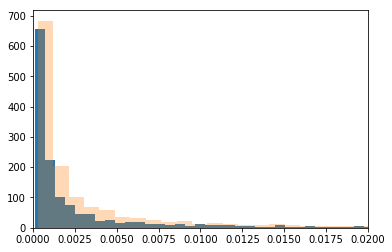

In [863]:
plt.hist(N[GOOD][np.isfinite(N[GOOD])],'auto')
plt.hist(stars[GOOD][np.isfinite(stars[GOOD])],'auto',alpha=0.3)
plt.xlim([0,0.02])
plt.show()

In [9]:
N = {}
for key in dbRuns:
    N[key] = np.empty_like(stars[key])
    for j, p in enumerate(stars[key]):
        N[key][j]= pm[key][j]*stars[key][j]

In [10]:
N_mean = []
for key in dbRuns:
    N_mean.append(np.nanmean(N[key]))
N_mean=np.array(N_mean)

In [11]:
ID_bad=np.where(N_mean==np.amin(N_mean))
ID_good=np.where(N_mean==np.amax(N_mean))

In [12]:
BAD, GOOD= dbRuns[ID_bad[0][0]],dbRuns[ID_good[0][0]]

In [11]:
bundleDicts[BAD]

{(1,
  'LSPMmetric'): <lsst.sims.maf.metricBundles.metricBundle.MetricBundle at 0x7f2bd12462b0>,
 (2,
  'StarDensity '): <lsst.sims.maf.metricBundles.metricBundle.MetricBundle at 0x7f2bd11e9f28>,
 (3,
  'TransienPM'): <lsst.sims.maf.metricBundles.metricBundle.MetricBundle at 0x7f2bd11f84e0>,
 (4,
  'confusionmetric'): <lsst.sims.maf.metricBundles.metricBundle.MetricBundle at 0x7f2bd11f8940>}

In [13]:
b={BAD:bundleDicts[BAD],GOOD:bundleDicts[GOOD]}

In [15]:
bundleDicts[GOOD][(1,
  'LSPMmetric')].setPlotDict({'cmap':'RdBu','colorMin':0,'colorMax':1,'title':GOOD+', detected fraction of novelties'})
bundleDicts[BAD][(1,
  'LSPMmetric')].setPlotDict({'cmap':'RdBu','colorMin':0,'colorMax':1,'title':BAD+', detected fraction of novelties'})

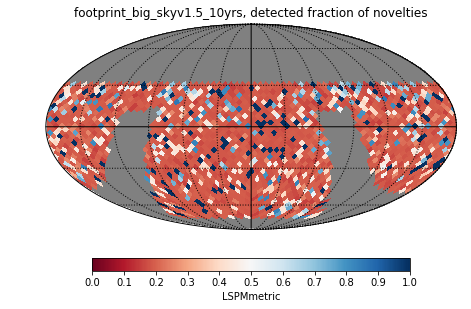

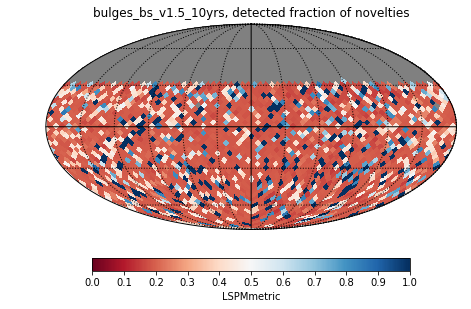

In [16]:
plotSky(b,(1,
  'LSPMmetric'))

/home/idies/lsst/python/miniconda3-4.7.10/envs/lsst-scipipe-4d7b902/lib/python3.7/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


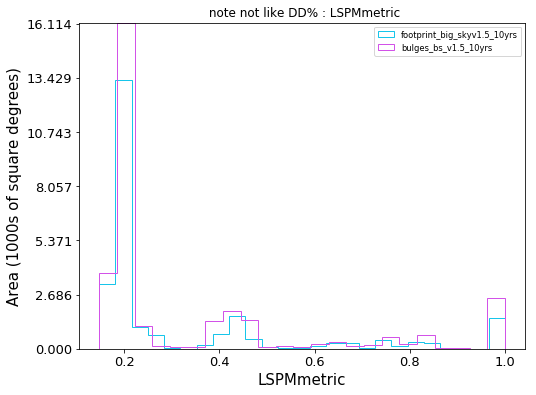

In [17]:
plotHist(b,(1,
  'LSPMmetric'))

In [795]:
ra

array([ 98.91791981, 101.81297206, 104.79676789, ...,  99.70321845,
       102.94222347, 106.28803529])

In [ ]:
output= pd.concat([pd.DataFrame(lam[key]) for key in bundleDicts.keys()],axis=1)
output.columns=bundleDicts.keys()
output.to_csv('likelihood_score_DD.csv', index=False)

In [35]:
name_tick=[] 
for key in dbRuns:#bundleDicts.keys(): 
#if 'noddf' in key: 
#    continue 
#else: 
    n= key.split('_') 
    if 'v1.5' in n: 
        n.remove('v1.5') 
    else: 
        word=[] 
        for s in n[-2]: 
            word.append(s) 
            word[0].replace('v','') 
            word[0].replace('1','')  
            word[0].replace('.','')  
            word[0].replace('5','')  
        sub ='' 
        n[-2]= sub.join(word) 
    n.remove('10yrs') 
    s=' ' 
    name_tick.append(s.join(n))

In [898]:
FomLS=np.empty(len(dbRuns)) 
FomPMT=np.empty(len(dbRuns)) 
FomC =np.empty(len(dbRuns)) 
#for i, key in enumerate(bundleDicts.keys()): 
for i, key in enumerate(dbRuns): 
 #if 'noddf' in key: 
 #    continue 
 #else: 
    if len(pm[key])>0: 
        pm[key]=np.array(pm[key],dtype=np.float64)[~np.isnan(np.array(pm[key],dtype=np.float64))]
        ID_pm=np.where((pm[key]<1)) 
         #lv,lb =np.histogram(np.array(pm[key])[ID_pm],'auto') 
         #l_fom = (lb[1:len(lb)]+lb[0:len(lb)-1])/2*lv 
         #FomLS.append(l_fom.sum()/lv.sum()/(3*np.std(np.array(pm[key])[ID_pm]))*np.mean(np.array(pm[key])[ID_pm])) 
        FomLS[i] = np.median(np.array(pm[key])[ID_pm])/(3*np.std(1-np.array(pm[key])[ID_pm])) 
    else: 
         FomLS[i] = np.nan 
         #FomLS.append(0) 
    if len(conf[key])>0:     
        conf[key]=np.array(conf[key],dtype=np.float64)[~np.isnan(np.array(conf[key],dtype=np.float64))]
        ID_conf=np.where((conf[key]!=0)) 
         #cv,cb =np.histogram(np.array(conf[key])[ID_conf],'auto') 
         #c_fom = (cb[1:len(cb)]+cb[0:len(cb)-1])/2*cv 
         #FomC.append(c_fom.sum()/cv.sum()/(np.std(np.array(conf[key])[ID_conf]))*norm_coeff[i]) 
        FomC[i]=np.absolute(np.median(np.array(conf[key])[ID_conf])/(3*np.std(np.array(conf[key])[ID_conf])))#/norm_coeff[i]*(len(ID_conf)) 
    else: 
         FomC[i] = np.nan 
         #FomC.append(0) 
    if len(frac[key])>0: 
        frac[key]=np.array(frac[key],dtype=np.float64)[~np.isnan(np.array(frac[key],dtype=np.float64))]
        ID_frac=np.where((np.isnan(frac[key])==False)) 
         #fv,fb=np.histogram(np.array(frac[key])[ID_frac],'auto')  
         #f_fom = (fb[1:len(fb)]+fb[0:len(fb)-1])/2*fv    
         #FomPMT.append(f_fom.sum()/fv.sum()*np.mean(np.array(frac[key])[ID_frac]))#/(3*np.std(np.array(frac[key])[ID_frac]))) 
        FomPMT[i] = np.absolute(np.median(np.array(frac[key])[ID_frac]))/(3*np.std(np.array(frac[key])[ID_frac])) 
    else: 
         FomPMT[i] = np.nan 
         #FomPMT.append(0) 
#FomLS=np.array(FomLS) 
#FomPMT=np.array(FomPMT) 
#FomC= np.array(FomC) 
idx=np.argsort(FomC+FomPMT+FomLS) 
idx=idx[::-1]

ValueError: arrays must all be same length

In [912]:
ScoreLS= pd.DataFrame(FomLS/3) 
ScoreLS.to_csv('Score_LS.cvs',index=False) 
ScoreCI= pd.DataFrame(FomC/3) 
ScoreCI.to_csv('Score_CI.cvs',index=False) 
ScorePMT= pd.DataFrame(FomPMT/3) 
ScorePMT.to_csv('Score_PMT.cvs',index=False)

In [ ]:
FomLS = pd.read_csv('Score_LS.cvs') 
FomLS = np.array(FomLS['0']) 
FomC = pd.read_csv('Score_CI.cvs') 
FomC = np.array(FomC['0']) 
FomPMT = pd.read_csv('Score_PMT.cvs') 
FomPMT = np.array(FomPMT['0']) 
idx=np.argsort(FomC+FomPMT+FomLS) 
idx=idx[::-1]

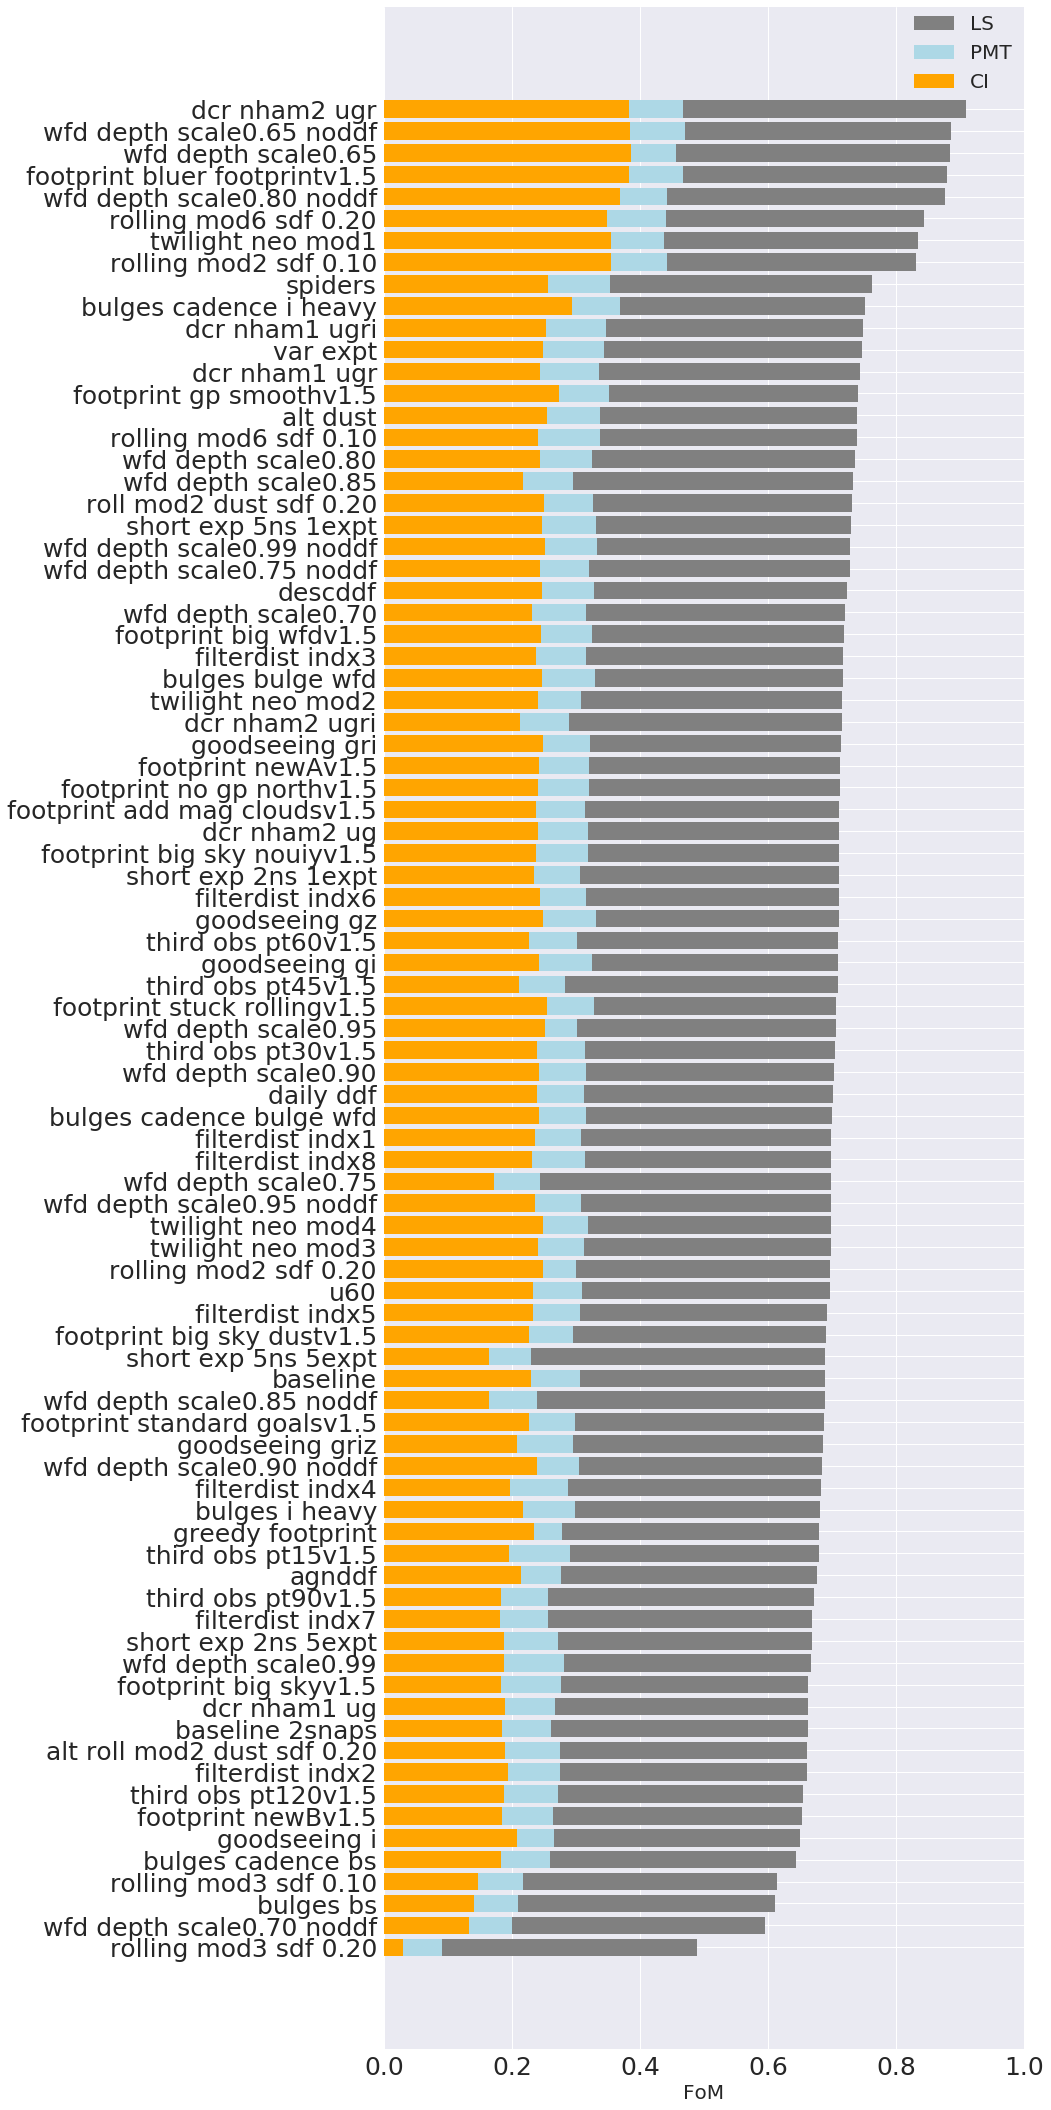

In [915]:
plt.style.use('seaborn') 
plt.rc('legend', fontsize=25) 
plt.rc('xtick',labelsize=25) 
fig, ax = plt.subplots(figsize=(15,30)) 
y_pos = np.arange(len(name_tick)) 
ax.barh(y_pos,(FomLS[idx]+FomC[idx]+FomPMT[idx])/3, align='center',color='grey',label='LS ') 
ax.barh(y_pos,(FomPMT[idx]+FomC[idx])/3, align='center',color='lightblue' ,label='PMT') 
ax.barh(y_pos,FomC[idx]/3, align='center', color= 'orange',label='CI') 
ax.set_xlim([0,1]) 
ax.set_yticks(y_pos[idx]) 
ax.set_yticklabels(name_tick, size=25) 
ax.invert_yaxis()  # labels read top-to-bottom 
ax.set_xlabel('FoM', size=20) 
ax.legend(bbox_to_anchor=(0.8, 0.95),fontsize=20) 
plt.tight_layout() 
#plt.savefig('FOM_astrometry_2yrs_v1p5.png')

In [902]:
df_plot = pd.DataFrame({'LS':FomLS/3,'CI':FomC/3,'PMT':FomPMT/3})

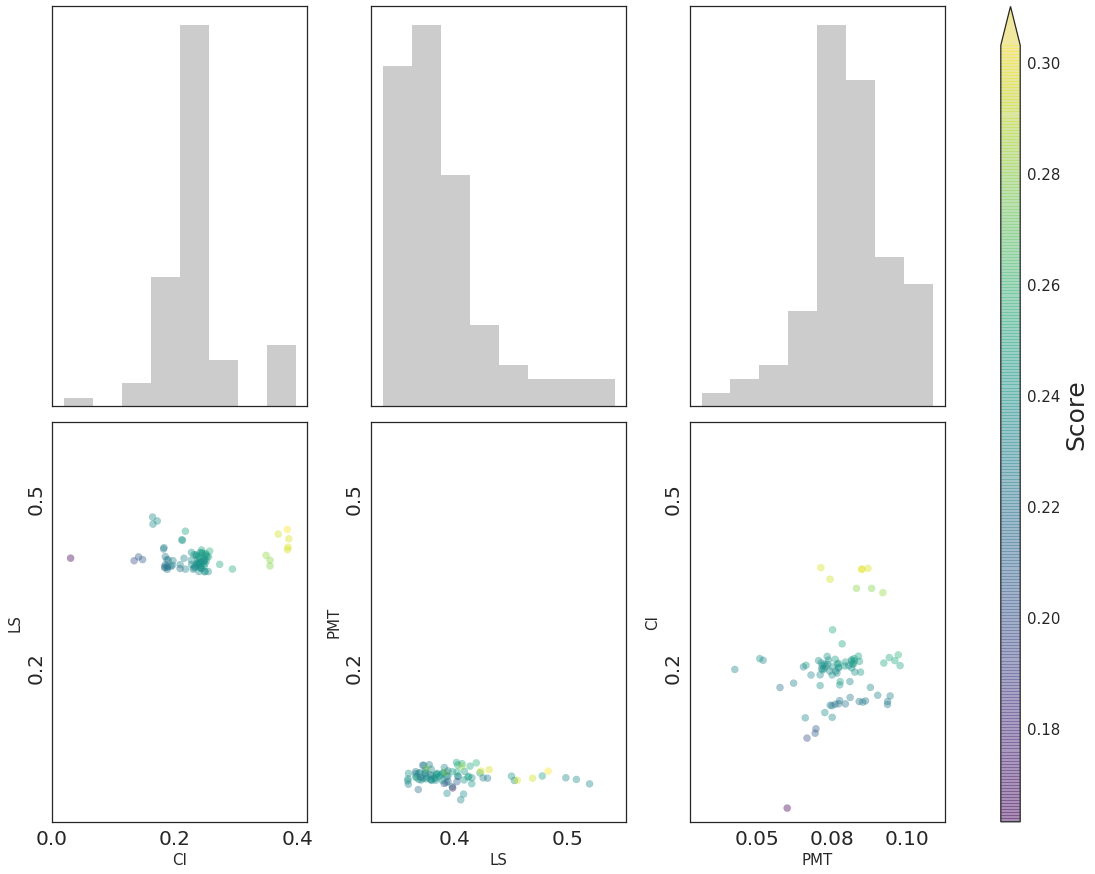

In [922]:
import matplotlib as mpl 
import seaborn as sns 
from scipy.stats import gaussian_kde
from matplotlib.ticker import FormatStrFormatter 
import matplotlib.gridspec as gridspec 
import matplotlib.ticker as plticker


mpl.rcParams.update({'font.size': 20}) 
#plt.rc('legend', fontsize=25) 
plt.rc('xtick',labelsize=20) 
plt.rc('ytick',labelsize=20) 
plt.rcParams['axes.grid']= False 
plt.rcParams['axes.edgecolor']= '0.15' 
plt.rcParams['axes.linewidth']= 1.25 
fig = plt.figure(figsize=(20,15)) 
grid = gridspec.GridSpec(2, 3, wspace=0.25, hspace=0.04) 
for i ,m in zip(np.arange(0,6,1), ['CI','LS','PMT']*2): 
    ax=plt.Subplot(fig, grid[i]) 
    if i in [0,1,2]: 
         #df_p=pd.DataFrame(df_plot[m]) 
        #sns.kdeplot(df_plot[m],color='gray', shade=True,ax=ax, alpha=0.3, legend=False) 
        sns.distplot(df_plot[m],color='gray',hist=True,kde=False,bins=8,ax=ax)
     #ax.hist(df_plot[m], bins='auto', histtype='step',lw=2,color='k') 
        ax.patch.set_facecolor('white') 
        ax.xaxis.set_major_formatter(FormatStrFormatter('%.1f')) 
        ax.get_xaxis().set_visible(False) 
        ax.get_yaxis().set_visible(False) 
        fig.add_subplot(ax) 

    else: 
        if i ==3: 
            xy = np.vstack([df_plot['CI'],df_plot['LS']]) 
            z = gaussian_kde(xy)(xy) 
            ax.scatter(df_plot['CI'],df_plot['LS'],c=(df_plot['CI']+df_plot['PMT']+df_plot['LS'])/3, s=50,cmap='viridis', marker='o',alpha=.4) 
            ax.grid(False) 
            loc = plticker.MultipleLocator(base=0.25) # this locator puts ticks at regular intervals
            ax.yaxis.set_major_locator(loc)
            ax.set_ylim([0.01,0.6]) 
            ax.patch.set_facecolor('white') 
            ax.set_ylabel('LS', fontsize=15) 
            ax.set_xlabel('CI', fontsize=15) 
            #ax.xaxis.set_tick_params(rotation=90)
            ax.yaxis.set_tick_params(rotation=90)
            ax.xaxis.set_major_formatter(FormatStrFormatter('%.1f')) 
            ax.yaxis.set_major_formatter(FormatStrFormatter('%.1f')) 
        elif i ==4: 
            xy = np.vstack([df_plot['LS'],df_plot['PMT']]) 
            z = gaussian_kde(xy)(xy) 
            ax.scatter(df_plot['LS'],df_plot['PMT'], c=(df_plot['CI']+df_plot['PMT']+df_plot['LS'])/3,s=50,cmap='viridis', marker='o',alpha=.4) 
            ax.grid(False) 
            ax.set_ylim([0.01,0.6]) 
            loc = plticker.MultipleLocator(base=0.25) # this locator puts ticks at regular intervals
            ax.yaxis.set_major_locator(loc)
            ax.patch.set_facecolor('white') 
            ax.set_xlabel('LS', fontsize=15) 
            ax.set_ylabel('PMT', fontsize=15) 
            #ax.xaxis.set_tick_params(rotation=90)
            ax.yaxis.set_tick_params(rotation=90)
            ax.xaxis.set_major_formatter(FormatStrFormatter('%.1f')) 
            ax.yaxis.set_major_formatter(FormatStrFormatter('%.1f')) 
        elif i ==5: 
            xy = np.vstack([df_plot['LS'],df_plot['PMT']]) 
            z = gaussian_kde(xy)(xy) 
            ax.scatter(df_plot['PMT'],df_plot['CI'], c=(df_plot['CI']+df_plot['PMT']+df_plot['LS'])/3,s=50,cmap='viridis', marker='o',alpha=.4) 
            ax.grid(False)          
            ax.set_ylim([0.01,0.6]) 
            loc = plticker.MultipleLocator(base=0.25) # this locator puts ticks at regular intervals
            ax.yaxis.set_major_locator(loc)
            ax.set_xlabel('PMT', fontsize=15) 
            ax.set_ylabel('CI', fontsize=15) 
            ax.patch.set_facecolor('white') 
            #ax.xaxis.set_tick_params(rotation=90)
            ax.yaxis.set_tick_params(rotation=90)
            ax.xaxis.set_major_formatter(FormatStrFormatter('%.2f')) 
            ax.yaxis.set_major_formatter(FormatStrFormatter('%.1f')) 
        fig.add_subplot(ax) 

all_axes = fig.get_axes() 
cax,kw = mpl.colorbar.make_axes([axs for axs in all_axes], aspect=40) 
cbar= plt.colorbar(all_axes[3].get_children()[0],extend='max', cax=cax,**kw) 
#cbar.set_ticks([]) 
cbar.ax.tick_params(labelsize=15)  
cbar.set_label('Score', size=25) 
fig.tight_layout() 
fig.show() 
#fig.savefig('corner_score_v2.png')

### Likelihood Score distribution

In [541]:
point = metricSky1.slicer.getSlicePoints()

In [542]:
point

{'sid': array([0]), 'ra': array([2.61968193]), 'dec': array([0.03809775])}

In [660]:
bundleDicts

{'twilight_neo_mod2_v1.5_10yrs': {(1,
   'LSPMmetric'): <lsst.sims.maf.metricBundles.metricBundle.MetricBundle at 0x7f342d53abe0>,
  (2,
   'LSPMmetric'): <lsst.sims.maf.metricBundles.metricBundle.MetricBundle at 0x7f3430d0bf98>}}

In [630]:
pd.DataFrame(bundleDicts[key][(2,'LSPMmetric')].metricValues[np.where(bundleDicts[key][(2,'LSPMmetric')].metricValues.mask == False)])[0]

0    {'LS': {'L_PM': [0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...
Name: 0, dtype: object

In [485]:
#position = [point['ra'][0], point['dec'][]]
position = galacticFromEquatorial(point['ra'][id_maxpos[0]], point['dec'][[id_maxpos[0]]])
print(position)

(array([98.36059661]), array([-59.93422644]))


/home/idies/lsst/python/miniconda3-4.7.10/envs/lsst-scipipe-4d7b902/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  


In [465]:
data, hist  ={},{} 
for key in bundleDicts.keys(): 
    data[key]=pd.DataFrame(bundleDicts[key][(6,'LSPMmetric')].metricValues[np.where(bundleDicts[key][(1,'LSPMmetric')].metricValues.mask == False)])[0] 
    hist[key]={} 
    hist[key]['LS']=[] 
    hist[key]['LS_out']=[] 
    hist[key]['PM']=[] 
    hist[key]['PM_out']=[] 
    hist[key]['mag']=[] 
    for i in range(len(data[key])):         
        if data[key][i] is None: 
            continue
        else:
            for j in range(len(data[key][i]['LS']['L_PM'])): 
                hist[key]['LS'].append(data[key][i]['LS']['L_PM'][j]) 
            for k in range(len(data[key][i]['LS']['L_PMout'])): 
                hist[key]['LS_out'].append(data[key][i]['LS']['L_PMout'][k]) 
            for l in range(len(data[key][i]['LS']['mag'])): 
                hist[key]['mag'].append(data[key][i]['LS']['mag'][l]) 
            for j in range(len(data[key][i]['LS']['L_PM'])): 
                hist[key]['PM'].append(data[key][i]['LS']['PM'][j]) 
            for k in range(len(data[key][i]['LS']['PM_OUT'])): 
                hist[key]['PM_out'].append(data[key][i]['LS']['PM_OUT'][k])
    hist[key]['LS']=np.hstack(np.array(hist[key]['LS'])) 
    hist[key]['LS_out']=np.hstack(np.array(hist[key]['LS_out']))
    hist[key]['PM']=np.hstack(np.array(hist[key]['PM'])) 
    hist[key]['PM_out']=np.hstack(np.array(hist[key]['PM_out']))
    hist[key]['mag']=np.hstack(np.array(hist[key]['mag']))

KeyboardInterrupt: 

In [661]:
data[key]=pd.DataFrame(bundleDicts[key][(2,'LSPMmetric')].metricValues[np.where(bundleDicts[key][(2,'LSPMmetric')].metricValues.mask == False)])[0]
pos_pm = [] 
for i in range(np.size(data[key])):
    if (data[key][i] is None):
        continue
    else:
        m = np.mean(data[key][i]['LS']['PM'])
        if (len(data[key][i]['LS']['PM'])>1000):
            pos_pm.append([i,m])
pos_pm=np.array(pos_pm)

TypeError: 'float' object is not subscriptable

In [595]:
data[key][0:8]

0    {'LS': {'L_PM': [0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...
1    {'LS': {'L_PM': [0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...
2    {'LS': {'L_PM': [0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...
3    {'LS': {'L_PM': [0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...
4                                                 None
5    {'LS': {'L_PM': [0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...
6    {'LS': {'L_PM': [0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...
7    {'LS': {'L_PM': [0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...
Name: twilight_neo_mod2_v1.5_10yrs, dtype: object

In [501]:
galacticFromEquatorial(29.01219,1.10383)

(154.36721781945494, -57.76975385626923)

In [492]:
id_maxpos = np.where(pos_pm[1:]==np.amax(pos_pm[1:]))
id_minpos = np.where(pos_pm[1:]==np.amin(pos_pm[1:]))

In [91]:
df=pd.DataFrame(hist[key])
df.to_csv('pm-sims.csv')

In [493]:
id_maxpos

(array([616]), array([0]))

In [292]:
position[1][0]

-25.662050800633242

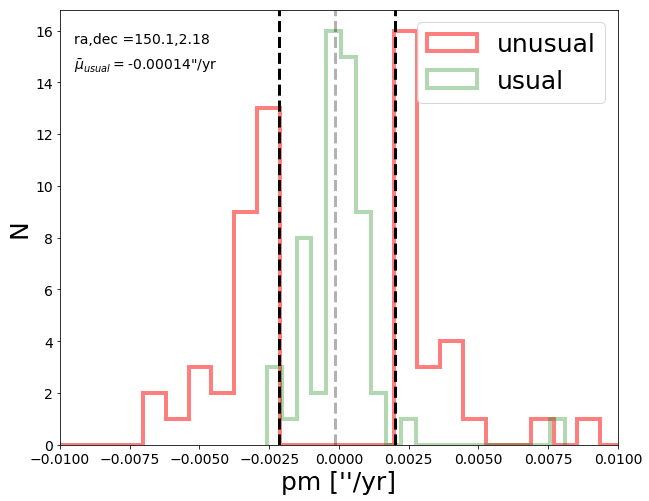

In [670]:
fig, ax= plt.subplots(figsize=(10,8))
plt.hist(data[key][0]['LS']['PM_OUT'], bins=50, color='red',histtype='step', lw=4,alpha =.5, label= 'unusual')
plt.hist(data[key][0]['LS']['PM'], bins=20, color='green',histtype='step',lw=4, alpha =.3, label='usual')
plt.xlabel('pm [\'\'/yr]', size=25)
plt.legend(loc='upper right',fontsize=25)
ax.tick_params(axis='both', which='major', labelsize=14)
plt.ylabel('N', size=25)
plt.xlim([-0.01,0.01])
#good=(data[key][0]['LS']['PM']< 0.03) & (hist[metric_runs[0]]['PM']>-0.03)
quant = np.percentile(data[key][0]['LS']['PM'],[2.5,97.5,50])
plt.text(-0.0095,15.5,'ra,dec ='+str(np.round(150.09671833,2))+','+str(np.round(2.18284020,2)),fontsize=14)
plt.text(-0.0095,14.5,r'$\bar{\mu}_{usual}=$'+str(np.round(quant[2],5))+'"/yr',fontsize=14)
plt.axvline(quant[2], color='k', alpha=.3, linestyle='dashed', linewidth=3)
plt.axvline(quant[0], color='k', linestyle='dashed', linewidth=3)
plt.axvline(quant[1], color='k', linestyle='dashed', linewidth=3)
#plt.ylim([0,12000])
plt.savefig('COSMOS_stream.png')
plt.show()

4.529540565264012e-05


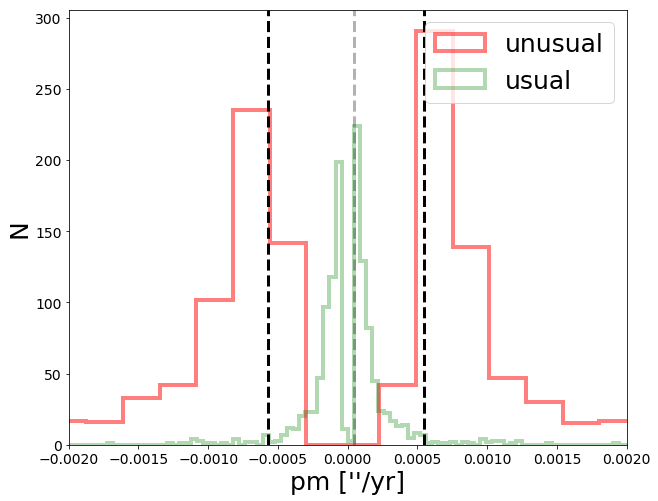

In [153]:
fig, ax= plt.subplots(figsize=(10,8))
plt.hist(data[key][6]['LS']['PM_OUT'], bins='auto', color='red',histtype='step', lw=4,alpha =.5, label= 'unusual')
plt.hist(data[key][6]['LS']['PM'], bins='auto', color='green',histtype='step',lw=4, alpha =.3, label='usual')
plt.xlabel('pm [\'\'/yr]', size=25)
plt.legend(fontsize=25)
ax.tick_params(axis='both', which='major', labelsize=14)
plt.ylabel('N', size=25)
plt.xlim([-0.002,0.002])
#good=(data[key][0]['LS']['PM']< 0.03) & (hist[metric_runs[0]]['PM']>-0.03)
quant = np.percentile(data[key][6]['LS']['PM'],[2.5,97.5,50])
print(quant[2])
plt.axvline(quant[2], color='k', alpha=.3, linestyle='dashed', linewidth=3)
plt.axvline(quant[0], color='k', linestyle='dashed', linewidth=3)
plt.axvline(quant[1], color='k', linestyle='dashed', linewidth=3)
#plt.ylim([0,12000])
#plt.savefig('uniform_pmunusual.png')
plt.show()

3.4925488723916454e-05


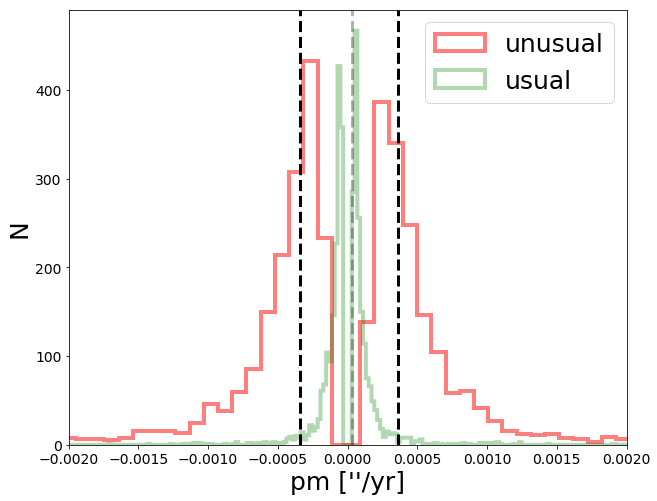

In [560]:
fig, ax= plt.subplots(figsize=(10,8))
plt.hist(data[key][0]['LS']['PM_OUT'], bins='auto', color='red',histtype='step', lw=4,alpha =.5, label= 'unusual')
plt.hist(data[key][0]['LS']['PM'], bins='auto', color='green',histtype='step',lw=4, alpha =.3, label='usual')
plt.xlabel('pm [\'\'/yr]', size=25)
plt.legend(fontsize=25)
ax.tick_params(axis='both', which='major', labelsize=14)
plt.ylabel('N', size=25)
plt.xlim([-0.002,0.002])
#good=(data[key][0]['LS']['PM']< 0.03) & (hist[metric_runs[0]]['PM']>-0.03)
quant = np.percentile(data[key][0]['LS']['PM'],[2.5,97.5,50])
print(quant[2])
plt.axvline(quant[2], color='k', alpha=.3, linestyle='dashed', linewidth=3)
plt.axvline(quant[0], color='k', linestyle='dashed', linewidth=3)
plt.axvline(quant[1], color='k', linestyle='dashed', linewidth=3)
#plt.ylim([0,12000])
#plt.savefig('uniform_pmunusual.png')
plt.show()

3.666374571350473e-05


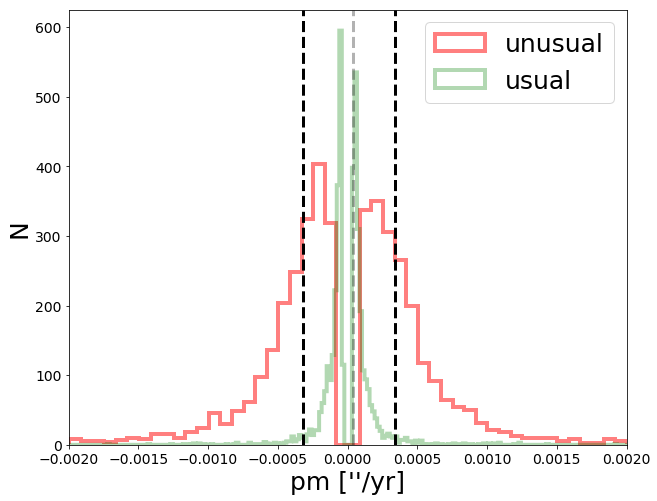

In [152]:
fig, ax= plt.subplots(figsize=(10,8))
plt.hist(data[key][1]['LS']['PM_OUT'], bins='auto', color='red',histtype='step', lw=4,alpha =.5, label= 'unusual')
plt.hist(data[key][1]['LS']['PM'], bins='auto', color='green',histtype='step',lw=4, alpha =.3, label='usual')
plt.xlabel('pm [\'\'/yr]', size=25)
plt.legend(fontsize=25)
ax.tick_params(axis='both', which='major', labelsize=14)
plt.ylabel('N', size=25)
plt.xlim([-0.002,0.002])
#good=(hist[metric_runs[0]]['PM']< 0.03) & (hist[metric_runs[0]]['PM']>-0.03)
quant = np.percentile(data[key][1]['LS']['PM'],[2.5,97.5,50])
print(quant[2])
plt.axvline(quant[2], color='k', alpha=.3, linestyle='dashed', linewidth=3)
plt.axvline(quant[0], color='k', linestyle='dashed', linewidth=3)
plt.axvline(quant[1], color='k', linestyle='dashed', linewidth=3)
#plt.ylim([0,12000])
#plt.savefig('uniform_pmunusual.png')
plt.show()

-0.00041445549656648356


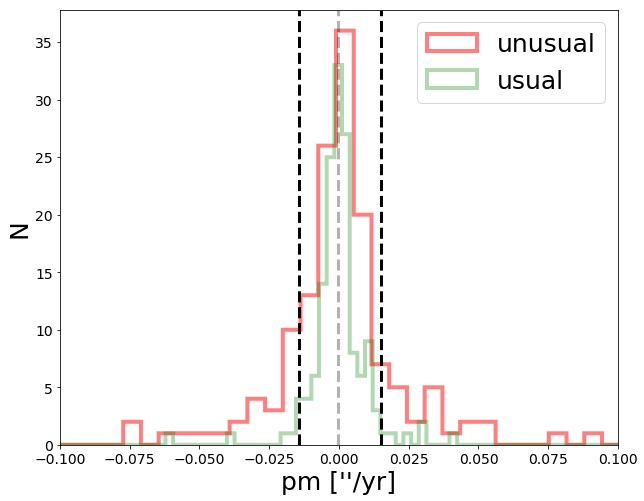

In [82]:
fig, ax= plt.subplots(figsize=(10,8))
plt.hist(hist[metric_runs[0]]['PM_out'], bins='auto', color='red',histtype='step', lw=4,alpha =.5, label= 'unusual')
plt.hist(hist[metric_runs[0]]['PM'], bins='auto', color='green',histtype='step',lw=4, alpha =.3, label='usual')
plt.xlabel('pm [\'\'/yr]', size=25)
plt.legend(fontsize=25)
ax.tick_params(axis='both', which='major', labelsize=14)
plt.ylabel('N', size=25)
plt.xlim([-0.1,0.1])
good=(hist[metric_runs[0]]['PM']< 0.03) & (hist[metric_runs[0]]['PM']>-0.03)
quant = np.percentile(hist[metric_runs[0]]['PM'][good],[2.5,97.5,50])
print(quant[2])
plt.axvline(quant[2], color='k', alpha=.3, linestyle='dashed', linewidth=3)
plt.axvline(quant[0], color='k', linestyle='dashed', linewidth=3)
plt.axvline(quant[1], color='k', linestyle='dashed', linewidth=3)
#plt.ylim([0,12000])
#plt.savefig('uniform_pmunusual.png')
plt.show()

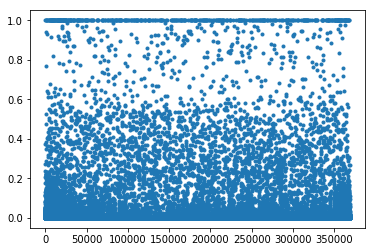

In [62]:
plt.plot(np.arange(len(hist[metric_runs[0]]['LS'][np.isfinite(hist[metric_runs[0]]['LS'])])),hist[metric_runs[0]]['LS'][np.isfinite(hist[metric_runs[0]]['LS'])],'.')

In [52]:
len(x)

1297

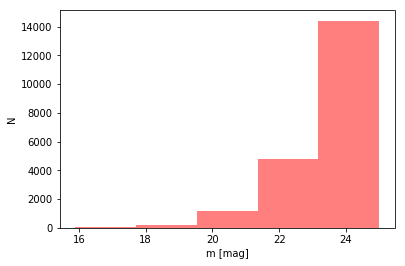

In [14]:
plt.hist(hist[metric_runs[0]]['mag'], bins=5, color='red', alpha =.5)
plt.xlabel('m [mag]')
plt.ylabel('N')
plt.show()

In [40]:
unusual=np.dstack((hist[metric_runs[0]]['PM_out'],hist[metric_runs[0]]['LS_out']))
usual=np.dstack((hist[metric_runs[0]]['PM'],hist[metric_runs[0]]['LS']))

In [41]:
bins_unusu=np.linspace(min(unusual[:,np.isfinite(hist[metric_runs[0]]['LS_out'])][0,:,0]),max(unusual[:,np.isfinite(hist[metric_runs[0]]['LS_out'])][0,:,0]), 1297)
index_unusu_bar=[np.where((unusual[:,np.isfinite(hist[metric_runs[0]]['LS_out'])][0,:,0]>bins_unusu[i])&(unusual[:,np.isfinite(hist[metric_runs[0]]['LS_out'])][0,:,0]<bins_unusu[i+1])) for i in range(len(bins_unusu)-1)] 
bins_usu=np.linspace(min(usual[:,np.isfinite(hist[metric_runs[0]]['LS'])][0,:,0]),max(usual[:,np.isfinite(hist[metric_runs[0]]['LS'])][0,:,0]), 1297)
index_usu_bar=[np.where((usual[:,np.isfinite(hist[metric_runs[0]]['LS'])][0,:,0]>bins_usu[i])&(usual[:,np.isfinite(hist[metric_runs[0]]['LS'])][0,:,0]<bins_usu[i+1])) for i in range(len(bins_usu)-1)] 
bar1_y = [np.sum(unusual[:,np.isfinite(hist[metric_runs[0]]['LS_out'])][0,index_unusu_bar[i],1]) for i in range(len(index_unusu_bar))]
bar2_y = [np.sum(usual[:,np.isfinite(hist[metric_runs[0]]['LS'])][0,index_usu_bar[i],1]) for i in range(len(index_usu_bar))]


In [42]:
from scipy import interpolate
p  = interpolate.splrep(bins_unusu[0:-1],bar1_y/np.nansum(bar1_y), s=0)
p2  = interpolate.splrep(bins_usu[0:-1],bar2_y/np.nansum(bar2_y), s=0)
y = interpolate.splev(np.arange(-1,1,0.01), p, der=0)
y2 = interpolate.splev(np.arange(-1,1,0.001), p2, der=0)

In [ ]:
from scipy import interpolate
p  = interpolate.splrep(hist[metric_runs[0]]['_out'],bar1_y/np.nansum(bar1_y), s=0)
p2  = interpolate.splrep(bins_usu[0:-1],bar2_y/np.nansum(bar2_y), s=5)
y = interpolate.splev(np.arange(-1,1,0.01), p, der=0)
y2 = interpolate.splev(np.arange(-1,1,0.01), p2, der=0)

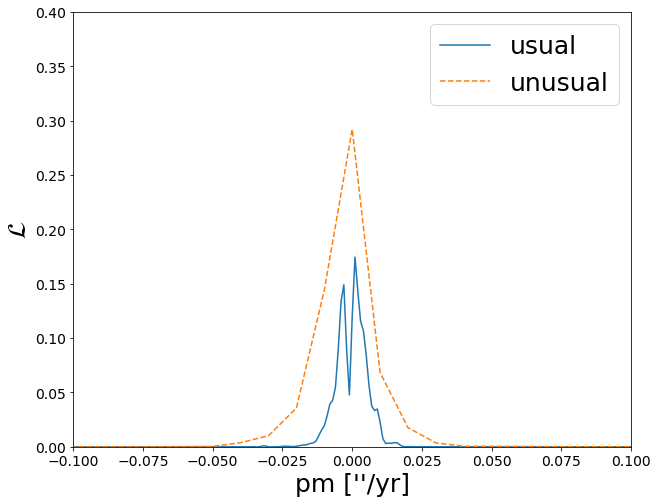

In [44]:
fig, ax= plt.subplots(figsize=(10,8))
plt.plot(np.arange(-1,1,0.001),y2,'-',label='usual')
plt.plot(np.arange(-1,1,0.01),y,'--', label='unusual')
plt.ylim([0,0.4])
plt.xlim([-0.1,0.1])
ax.tick_params(axis='both', which='major', labelsize=14)
plt.legend(fontsize=25)
plt.xlabel('pm [\'\'/yr]', size=25)
plt.ylabel(r'$\mathcal{L}$', size= 25)
#plt.savefig('uniform_likelihood.png')
plt.show()

In [100]:
valL_out[np.isfinite(valL_out)]/np.sum(valL_out[np.isfinite(valL_out)])

array([nan, nan, nan, ..., nan, nan, nan])

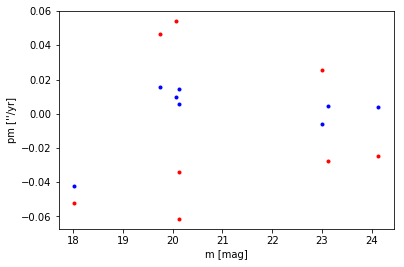

In [18]:
plt.plot(hist[metric_runs[0]]['mag'],hist[metric_runs[0]]['PM_out'],'r.')
plt.plot(hist[metric_runs[0]]['mag'],hist[metric_runs[0]]['PM'],'b.')
plt.ylabel('pm [\'\'/yr]')
plt.xlabel('m [mag]')
plt.show()

Text(0.5, 0.98, 'Baseline 2 yrs')

<Figure size 1440x720 with 0 Axes>

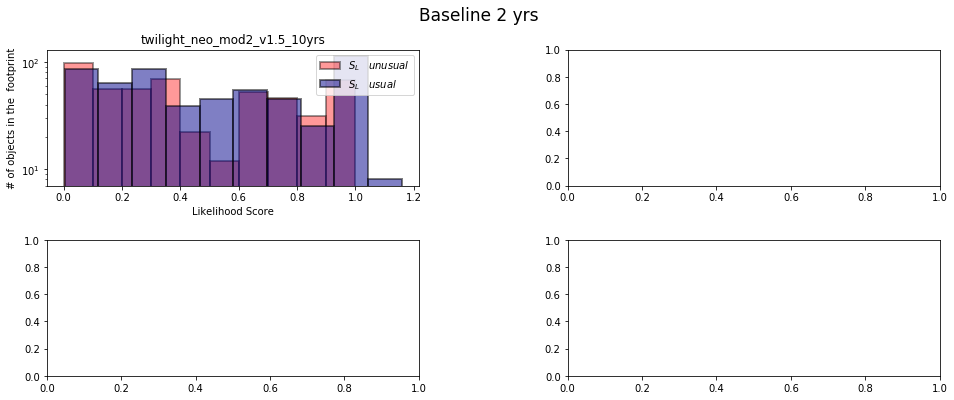

In [36]:
import seaborn as sn
fig = plt.figure(figsize=(20,10)) 
fig, ax = plt.subplots(2, 2, figsize=(16,6)) 
fig.subplots_adjust(hspace=0.4, wspace=0.4) 
for i, key in enumerate([metric_runs[0]]): 
 #value, bins = np.histogram(lam[key]['LS'], 50) 
 #v_out, b_out = np.histogram(lam[key]['LS_out'],10) 
 #ax = fig.add_subplot(2, 2, i+1) 
    zeromaskLS =np.isfinite(hist[key]['LS']) 
    plthist= pd.DataFrame(hist[key]['LS'][zeromaskLS]) 
    zeromask =np.isfinite(hist[key]['LS_out']) 
    plthistout= pd.DataFrame(hist[key]['LS_out'][zeromask]) 
    sn.distplot(plthistout[plthistout>0], color= 'red' ,  hist=True, kde=False,bins=10,norm_hist=False,hist_kws=dict(alpha=0.4,edgecolor='k' , linewidth=2), ax=ax[i // 2][i % 2], label=r'$S_L\hspace{1} unusual$') 
    sn.distplot(plthist[plthist>0], color= 'Darkblue' , hist=True, kde=False,bins=10,norm_hist=False,hist_kws=dict(alpha=0.5,edgecolor='k' , linewidth=2),ax=ax[i // 2][i % 2], label=r'$S_L\hspace{1} usual$') 
    #ax.hist(lam[key]['LS'],10,alpha=.3,histtype='step',lw=3, color='black', label='LS-usual') 
    #ax.hist(lam[key]['LS_out'],10,histtype='step',lw=3, color='orange', label='LS-unusual') 
    #ax[i // 2][i % 2].set_xlim([0,2]) 
    ax[i // 2][i % 2].set_yscale('log')
    ax[i // 2][i % 2].set_xlabel('Likelihood') 
    ax[i // 2][i % 2].set_ylabel('# of objects in the  footprint') 
    ax[i // 2][i % 2].set_title('{}'.format(metric_runs[i])) 
    if i ==0: 
        ax[i // 2][i % 2].legend() 
plt.suptitle('Baseline 2 yrs', size=17) 
#plt.savefig('hist_LS-dist.png')

### Sgr Simulation

In [ ]:
dataout_dens, cind_dens,H_dens,c_dens={},{},{},{}
for key in bundleDicts.keys():
    dataout_dens[key]=pd.DataFrame(bundleDicts[key][(1,'confusionmetric')].metricValues[np.where(bundleDicts[key][(1,'confusionmetric')].metricValues.mask == False)])[0]
    cind_dens[key]= {}
    H_dens[key]= {}
    c_dens[key]= {}
    for mag in dataout_dens[key][0].keys(): 
        cind_dens[key][mag] = []
        H_dens[key][mag] = []
        c_dens[key][mag] = []
    for i in range(len(dataout_dens[key])):        
        if dataout_dens[key][i]:
            for mag in dataout_dens[key][i].keys():
                cind_dens[key][mag].append(dataout_dens[key][i][mag]['num'])
                H_dens[key][mag].append(dataout_dens[key][i][mag]['Hg'])
                c_dens[key][mag].append(dataout_dens[key][i][mag]['g-r'])
    for mag in dataout_dens[key][0].keys(): 
        cind_dens[key][mag]=np.hstack(np.array(cind_dens[key][mag])[np.isfinite(np.array(cind_dens[key][mag]))])
        H_dens[key][mag]=np.hstack(np.array(H_dens[key][mag])[np.isfinite(np.array(H_dens[key][mag]))])
        c_dens[key][mag]=np.hstack(np.array(c_dens[key][mag])[np.isfinite(np.array(c_dens[key][mag]))])   

In [ ]:
dataout, cind_dist,H_dist,c_dist, label={},{},{},{},{}
for key in bundleDicts.keys():
    dataout[key]=pd.DataFrame(bundleDicts[key][(1,'confusionmetric')].metricValues[np.where(bundleDicts[key][(1,'confusionmetric')].metricValues.mask == False)])[0]
    cind_dist[key]= {}
    H_dist[key]= {}
    c_dist[key]= {}
    for mag in dataout[key][0].keys(): 
        cind_dist[key][mag] = []
        H_dist[key][mag] = []
        c_dist[key][mag] = []
    for i in range(len(dataout[key])):        
        if dataout[key][i]:
            for mag in dataout[key][i].keys():
                cind_dist[key][mag].append(dataout[key][i][mag]['num'])
                H_dist[key][mag].append(dataout[key][i][mag]['Hg'])
                c_dist[key][mag].append(dataout[key][i][mag]['g-r'])
    for mag in dataout[key][0].keys(): 
        cind_dist[key][mag]=np.hstack(np.array(cind_dist[key][mag])[np.isfinite(np.array(cind_dist[key][mag]))])
        H_dist[key][mag]=np.hstack(np.array(H_dist[key][mag])[np.isfinite(np.array(H_dist[key][mag]))])
        c_dist[key][mag]=np.hstack(np.array(c_dist[key][mag])[np.isfinite(np.array(c_dist[key][mag]))])
    

In [ ]:
import matplotlib as mpl
from itertools import product 
import matplotlib.gridspec as gridspec
for j, tup in enumerate([(3, 'PM2yrs')]):#enumerate([(2, 'PM5yrs'), (3, 'PM2yrs'), (4, 'PM1yrs'), (5, 'PM0p5yrs')]):
    mpl.rcParams.update({'font.size': 20})
    fig = plt.figure(figsize=(30,30))
    outer_grid = gridspec.GridSpec(4, 4, wspace=0.0, hspace=0.04)
    for i, (mag, key) in enumerate(product([0,1,2,3],dbRuns[0:4])):
        n=key.split('_')
        n.remove('v1.4')
        n.remove('10yrs')
        sep='_'
        name= sep.join(n)
        inner_grid = gridspec.GridSpecFromSubplotSpec(
          2, 1, subplot_spec=outer_grid[i], wspace=0.0, hspace=0.0)
        for j, mode in enumerate(['density','distance']):
            ax = plt.Subplot(fig, inner_grid[j])
            ax = plt.Subplot(fig, inner_grid[j], sharey=ax, sharex=ax)

            if mode=='density'and i>=4 and i not in [0,4,8,12,13,14,15]:
                try:
                    zero_mask = np.where(cind_dens[key][tup][mag]==0)
                    non_zero_mask = np.where(cind_dens[key][tup][mag]!=0)
                    plotdata=pd.DataFrame(np.matrix([H_dens[key][tup][mag][non_zero_mask],c_dens[key][tup][mag][non_zero_mask],cind_dens[key][tup][mag][non_zero_mask]]).T, columns=['Hg','g-r','detected in the 3sigma limit area'])
                    #zerodata=pd.DataFrame(np.matrix([H[key][mag][zero_mask],c[key][mag][zero_mask]]).T, columns=['Hg','g-r'])
                    im=plotdata.plot.scatter(x='g-r', y='Hg',c='detected in the 3sigma limit area', cmap='Spectral_r',s=40,colorbar=False, ax=ax,xlim=[0,2], ylim=[4,21],vmin=0,vmax=0.6, alpha=.2)

                    im.annotate('{} '.format(np.round(1-np.size(H_dist[key][tup][mag][zero_mask])/(np.size(H_dist[key][tup][mag])),2)),[1.7,6.7], size=20)
                    im.annotate('{},   dm={} mag,'.format(mode,mag),[0.05,6.7], size=20)
                    im.annotate('N = {} '.format(int(normdens_factor[key][tup][mag])-1),[0.05,8.5], size=20)
                    im.invert_yaxis()
                    im.set_ylabel('')
                    im.set_xlabel('')
                    im.get_xaxis().set_visible(False)
                    im.get_yaxis().set_visible(False)
                    fig.add_subplot(ax)
                except:
                    continue
            if mode=='distance'and i>=4 and i not in [0,4,8,12,13,14,15]:
                try:
                    zero_mask = np.where(cind_dist[key][tup][mag]==0)
                    non_zero_mask = np.where(cind_dist[key][tup][mag]!=0)
                    plotdata=pd.DataFrame(np.matrix([H_dens[key][tup][mag][non_zero_mask],c_dens[key][tup][mag][non_zero_mask],cind_dens[key][tup][mag][non_zero_mask]]).T, columns=['Hg','g-r','detected in the 3sigma limit area'])
                    #zerodata=pd.DataFrame(np.matrix([H[key][mag][zero_mask],c[key][mag][zero_mask]]).T, columns=['Hg','g-r'])
                    im=plotdata.plot.scatter(x='g-r', y='Hg',c='detected in the 3sigma limit area', cmap='Spectral_r',s=40,colorbar=False, ax=ax,xlim=[0,2], ylim=[4,21],vmin=0,vmax=0.6, alpha=.2)

                    im.annotate('{} '.format(np.round(1-np.size(H_dist[key][tup][mag][zero_mask])/(np.size(H_dist[key][tup][mag])),2)),[1.7,6.7], size=20)
                    im.annotate('{}, '.format(mode)  + r'$d_{new}=$'+'{} kpc,'.format(np.round(28*10**(mag/5),1)),[0.05,6.7], size=20)
                    im.annotate('N = {} '.format(int(normdist_factor[key][tup][mag])-1),[0.05,8.5], size=20)
                    im.invert_yaxis()
                    im.set_ylabel('')
                    im.set_xlabel('')
                    im.get_xaxis().set_visible(False)
                    im.get_yaxis().set_visible(False)
                    fig.add_subplot(ax)
                except:
                    continue

            elif mode=='density'and i in [4,8]:
                try:
                    zero_mask = np.where(cind_dens[key][tup][mag]==0)
                    non_zero_mask = np.where(cind_dens[key][tup][mag]!=0)
                    plotdata=pd.DataFrame(np.matrix([H_dens[key][tup][mag][non_zero_mask],c_dens[key][tup][mag][non_zero_mask],cind_dens[key][tup][mag][non_zero_mask]]).T, columns=['Hg','g-r','detected in the 3sigma limit area'])
                    #zerodata=pd.DataFrame(np.matrix([H[key][mag][zero_mask],c[key][mag][zero_mask]]).T, columns=['Hg','g-r'])
                    im=plotdata.plot.scatter(x='g-r', y='Hg',c='detected in the 3sigma limit area', cmap='Spectral_r',s=40,colorbar=False, ax=ax,xlim=[0,2], ylim=[4,21],vmin=0,vmax=0.6, alpha=.2)

                    im.annotate('{} '.format(np.round(1-np.size(H_dens[key][tup][mag][zero_mask])/(np.size(H_dens[key][tup][mag])),2)),[1.7,6.7], size=20)
                    im.annotate('{},   dm={} mag,'.format(mode,mag),[0.05,6.7], size=20)
                    im.annotate('N = {} '.format(int(normdens_factor[key][tup][mag])-1),[0.05,8.5], size=20)
                    im.invert_yaxis()
                    im.yaxis.set_label_coords(-0.15,0)
                    im.set_ylabel('Hg')
                    im.set_xlabel('')
                    im.get_xaxis().set_visible(False)
                    fig.add_subplot(ax)
                except:
                    continue
            elif mode=='distance'and i in [4,8]:
                try:
                    zero_mask = np.where(cind_dist[key][tup][mag]==0)
                    non_zero_mask = np.where(cind_dist[key][tup][mag]!=0)
                    plotdata=pd.DataFrame(np.matrix([H_dist[key][tup][mag][non_zero_mask],c_dist[key][tup][mag][non_zero_mask],cind_dist[key][tup][mag][non_zero_mask]]).T, columns=['Hg','g-r','detected in the 3sigma limit area'])
                    #zerodata=pd.DataFrame(np.matrix([H[key][mag][zero_mask],c[key][mag][zero_mask]]).T, columns=['Hg','g-r'])
                    im=plotdata.plot.scatter(x='g-r', y='Hg',c='detected in the 3sigma limit area', cmap='Spectral_r',s=40,colorbar=False, ax=ax,xlim=[0,2], ylim=[4,21],vmin=0,vmax=0.6, alpha=.2)

                    im.annotate('{} '.format(np.round(1-np.size(H_dist[key][tup][mag][zero_mask])/(np.size(H_dist[key][tup][mag])),2)),[1.7,6.7], size=20)
                    im.annotate('{}, '.format(mode)  + r'$d_{new}=$'+'{} kpc,'.format(np.round(28*10**(mag/5),1)),[0.05,6.7], size=20)
                    im.annotate('N = {} '.format(int(normdist_factor[key][tup][mag])-1),[0.05,8.5], size=20)
                    im.invert_yaxis()
                    im.yaxis.set_label_coords(-0.15,0)
                    im.set_ylabel('')
                    im.set_xlabel('')
                    im.get_xaxis().set_visible(False)
                    fig.add_subplot(ax)
                except:
                    continue
            elif mode=='density' and i in [1,2,3]:
                try:
                    zero_mask = np.where(cind_dens[key][tup][mag]==0)
                    non_zero_mask = np.where(cind_dens[key][tup][mag]!=0)
                    plotdata=pd.DataFrame(np.matrix([H_dens[key][tup][mag][non_zero_mask],c_dens[key][tup][mag][non_zero_mask],cind_dens[key][tup][mag][non_zero_mask]]).T, columns=['Hg','g-r','detected in the 3sigma limit area'])
                    #zerodata=pd.DataFrame(np.matrix([H[key][mag][zero_mask],c[key][mag][zero_mask]]).T, columns=['Hg','g-r'])
                    im=plotdata.plot.scatter(x='g-r', y='Hg',c='detected in the 3sigma limit area', cmap='Spectral_r',s=40,colorbar=False, ax=ax,xlim=[0,2], ylim=[4,21],vmin=0,vmax=0.6, alpha=.2,title='{} '.format(name))

                    im.annotate('{} '.format(np.round(1-np.size(H_dens[key][tup][mag][zero_mask])/(np.size(H_dens[key][tup][mag])),2)),[1.7,6.7], size=20)
                    im.annotate('{},   dm={} mag,'.format(mode,mag),[0.05,6.7], size=20)
                    im.annotate('N = {} '.format(int(normdens_factor[key][tup][mag])-1),[0.05,8.5], size=20)
                    im.invert_yaxis()
                    im.set_ylabel('')
                    im.set_xlabel('')
                    im.get_xaxis().set_visible(False)
                    im.get_yaxis().set_visible(False)
                    fig.add_subplot(ax)
                except:
                    continue
            elif mode=='distance' and i in [1,2,3]:
                try:
                    zero_mask = np.where(cind_dist[key][tup][mag]==0)
                    non_zero_mask = np.where(cind_dist[key][tup][mag]!=0)
                    plotdata=pd.DataFrame(np.matrix([H_dist[key][tup][mag][non_zero_mask],c_dist[key][tup][mag][non_zero_mask],cind_dist[key][tup][mag][non_zero_mask]]).T, columns=['Hg','g-r','detected in the 3sigma limit area'])
                    #zerodata=pd.DataFrame(np.matrix([H[key][mag][zero_mask],c[key][mag][zero_mask]]).T, columns=['Hg','g-r'])
                    im=plotdata.plot.scatter(x='g-r', y='Hg',c='detected in the 3sigma limit area', cmap='Spectral_r',s=40,colorbar=False, ax=ax,xlim=[0,2], ylim=[4,21],vmin=0,vmax=0.6, alpha=.2)
                    im.annotate('{} '.format(np.round(1-np.size(H_dist[key][tup][mag][zero_mask])/(np.size(H_dist[key][tup][mag])),2)),[1.7,6.7], size=20)
                    im.annotate('{}, '.format(mode)  + r'$d_{new}=$'+'{} kpc,'.format(np.round(28*10**(mag/5),1)),[0.05,6.7], size=20)
                    im.annotate('N = {} '.format(int(normdist_factor[key][tup][mag])-1),[0.05,8.5], size=20)
                    im.invert_yaxis()
                    im.set_ylabel('')
                    im.set_xlabel('')
                    im.get_xaxis().set_visible(False)
                    im.get_yaxis().set_visible(False)
                    fig.add_subplot(ax)
                except:
                    continue
            elif mode=='density' and i==0:
                try:
                    zero_mask = np.where(cind_dens[key][tup][mag]==0)
                    non_zero_mask = np.where(cind_dens[key][tup][mag]!=0)
                    plotdata=pd.DataFrame(np.matrix([H_dens[key][tup][mag][non_zero_mask],c_dens[key][tup][mag][non_zero_mask],cind_dens[key][tup][mag][non_zero_mask]]).T, columns=['Hg','g-r','detected in the 3sigma limit area'])
                    #zerodata=pd.DataFrame(np.matrix([H[key][mag][zero_mask],c[key][mag][zero_mask]]).T, columns=['Hg','g-r'])
                    im=plotdata.plot.scatter(x='g-r', y='Hg',c='detected in the 3sigma limit area', cmap='Spectral_r',s=40,colorbar=False, ax=ax,xlim=[0,2], ylim=[4,21],vmin=0,vmax=0.6, alpha=.2,title='{} '.format(name))

                    im.annotate('{} '.format(np.round(1-np.size(H_dens[key][tup][mag][zero_mask])/(np.size(H_dens[key][tup][mag])),2)),[1.7,6.7], size=20)
                    im.annotate('{},   dm={} mag,'.format(mode,mag),[0.05,6.7], size=20)
                    im.annotate('N = {} '.format(int(normdens_factor[key][tup][mag])-1),[0.05,8.5], size=20)
                    im.yaxis.set_label_coords(-0.15,0)
                    im.set_ylabel('Hg')
                    im.set_xlabel('')
                    im.invert_yaxis()
                    im.get_xaxis().set_visible(False)
                    fig.add_subplot(ax)
                except:
                    continue
            elif mode=='distance' and i==0:
                try:
                    zero_mask = np.where(cind_dist[key][tup][mag]==0)
                    non_zero_mask = np.where(cind_dist[key][tup][mag]!=0)
                    plotdata=pd.DataFrame(np.matrix([H_dist[key][tup][mag][non_zero_mask],c_dist[key][tup][mag][non_zero_mask],cind_dist[key][tup][mag][non_zero_mask]]).T, columns=['Hg','g-r','detected in the 3sigma limit area'])
                    #zerodata=pd.DataFrame(np.matrix([H[key][mag][zero_mask],c[key][mag][zero_mask]]).T, columns=['Hg','g-r'])
                    im=plotdata.plot.scatter(x='g-r', y='Hg',c='detected in the 3sigma limit area', cmap='Spectral_r',s=40,colorbar=False, ax=ax,xlim=[0,2], ylim=[4,21],vmin=0,vmax=0.6, alpha=.2)

                    im.annotate('{} '.format(np.round(1-np.size(H_dist[key][tup][mag][zero_mask])/(np.size(H_dist[key][tup][mag])),2)),[1.7,6.7], size=20)
                    im.annotate('{}, '.format(mode)  + r'$d_{new}=$'+'{} kpc,'.format(np.round(28*10**(mag/5),1)),[0.05,6.7], size=20)
                    im.annotate('N = {} '.format(int(normdist_factor[key][tup][mag])-1),[0.05,8.5], size=20)
                    im.yaxis.set_label_coords(-0.15,0)
                    im.set_ylabel('')
                    im.set_xlabel('')
                    im.invert_yaxis()
                    im.get_xaxis().set_visible(False)
                    fig.add_subplot(ax)
                except:
                    continue
            elif mode=='density'and i==12:
                try:
                    zero_mask = np.where(cind_dens[key][tup][mag]==0)
                    non_zero_mask = np.where(cind_dens[key][tup][mag]!=0)
                    plotdata=pd.DataFrame(np.matrix([H_dens[key][tup][mag][non_zero_mask],c_dens[key][tup][mag][non_zero_mask],cind_dens[key][tup][mag][non_zero_mask]]).T, columns=['Hg','g-r','detected in the 3sigma limit area'])
                    #zerodata=pd.DataFrame(np.matrix([H[key][mag][zero_mask],c[key][mag][zero_mask]]).T, columns=['Hg','g-r'])
                    im=plotdata.plot.scatter(x='g-r', y='Hg',c='detected in the 3sigma limit area', cmap='Spectral_r',s=40,colorbar=False, ax=ax,xlim=[0,2], ylim=[4,21],vmin=0,vmax=0.6, alpha=.2)

                    im.annotate('{} '.format(np.round(1-np.size(H_dens[key][tup][mag][zero_mask])/(np.size(H_dens[key][tup][mag])),2)),[1.7,6.7], size=20)
                    im.annotate('{},   dm={} mag,'.format(mode,mag),[0.05,6.7], size=20)
                    im.annotate('N = {} '.format(int(normdens_factor[key][tup][mag])-1),[0.05,8.5], size=20)
                    im.invert_yaxis()
                    im.yaxis.set_label_coords(-0.15,0)
                    im.set_ylabel('Hg')
                    im.set_xlabel('')
                    fig.add_subplot(ax)
                except:
                    continue
            if mode=='distance'and i==12:
                try:
                    zero_mask = np.where(cind_dist[key][tup][mag]==0)
                    non_zero_mask = np.where(cind_dist[key][tup][mag]!=0)
                    plotdata=pd.DataFrame(np.matrix([H_dist[key][tup][mag][non_zero_mask],c_dist[key][tup][mag][non_zero_mask],cind_dist[key][tup][mag][non_zero_mask]]).T, columns=['Hg','g-r','detected in the 3sigma limit area'])
                    #zerodata=pd.DataFrame(np.matrix([H[key][mag][zero_mask],c[key][mag][zero_mask]]).T, columns=['Hg','g-r'])
                    im=plotdata.plot.scatter(x='g-r', y='Hg',c='detected in the 3sigma limit area', cmap='Spectral_r',s=40,colorbar=False, ax=ax,xlim=[0,2], ylim=[4,21],vmin=0,vmax=0.6, alpha=.2)

                    im.annotate('{} '.format(np.round(1-np.size(H_dist[key][tup][mag][zero_mask])/(np.size(H_dist[key][tup][mag])),2)),[1.7,6.7], size=20)
                    im.annotate('{}, '.format(mode)  + r'$d_{new}=$'+'{} kpc,'.format(np.round(28*10**(mag/5),1)),[0.05,6.7], size=20)
                    im.annotate('N = {} '.format(int(normdist_factor[key][tup][mag])-1),[0.05,8.5], size=20)
                    im.invert_yaxis()
                    im.set_xlim([0,1.9])
                    im.yaxis.set_label_coords(-0.15,0)
                    im.set_ylabel('')
                    fig.add_subplot(ax)  
                except:
                    continue
            elif mode== 'distance' and i in [13,14,15]:
                try:
                    zero_mask = np.where(cind_dist[key][tup][mag]==0)
                    non_zero_mask = np.where(cind_dist[key][tup][mag]!=0)
                    plotdata=pd.DataFrame(np.matrix([H_dist[key][tup][mag][non_zero_mask],c_dist[key][tup][mag][non_zero_mask],cind_dist[key][tup][mag][non_zero_mask]]).T, columns=['Hg','g-r','detected in the 3sigma limit area'])
                    #zerodata=pd.DataFrame(np.matrix([H[key][mag][zero_mask],c[key][mag][zero_mask]]).T, columns=['Hg','g-r'])
                    im=plotdata.plot.scatter(x='g-r', y='Hg',c='detected in the 3sigma limit area', cmap='Spectral_r',s=40,colorbar=False, ax=ax,xlim=[0,2], ylim=[4,21],vmin=0,vmax=0.6, alpha=.2)
                    im.annotate('{} '.format(np.round(1-np.size(H_dist[key][tup][mag][zero_mask])/(np.size(H_dist[key][tup][mag])),2)),[1.7,6.7], size=20)
                    im.annotate('{}, '.format(mode)  + r'$d_{new}=$'+'{} kpc,'.format(np.round(28*10**(mag/5),1)),[0.05,6.7], size=20)
                    im.annotate('N = {} '.format(int(normdist_factor[key][tup][mag])-1),[0.05,8.5], size=20)
                    im.set_ylabel('')
                    im.set_xlim([0,1.9])
                    im.invert_yaxis()
                    im.get_yaxis().set_visible(False)
                    fig.add_subplot(ax)
                except:
                    continue
            elif mode== 'density' and i in [13,14,15]:
                try:
                    zero_mask = np.where(cind_dens[key][tup][mag]==0)
                    non_zero_mask = np.where(cind_dens[key][tup][mag]!=0)
                    plotdata=pd.DataFrame(np.matrix([H_dens[key][tup][mag][non_zero_mask],c_dens[key][tup][mag][non_zero_mask],cind_dens[key][tup][mag][non_zero_mask]]).T, columns=['Hg','g-r','detected in the 3sigma limit area'])
                    #zerodata=pd.DataFrame(np.matrix([H[key][mag][zero_mask],c[key][mag][zero_mask]]).T, columns=['Hg','g-r'])
                    im=plotdata.plot.scatter(x='g-r', y='Hg',c='detected in the 3sigma limit area', cmap='Spectral_r',s=40,colorbar=False, ax=ax,xlim=[0,2], ylim=[4,21],vmin=0,vmax=0.6, alpha=.2)
                    im.annotate('{} '.format(np.round(1-np.size(H_dens[key][tup][mag][zero_mask])/(np.size(H_dens[key][tup][mag])),2)),[1.7,6.7], size=20)
                    im.annotate('{},   dm={} mag,'.format(mode,mag),[0.05,6.7], size=20)
                    im.annotate('N = {} '.format(int(normdens_factor[key][tup][mag])-1),[0.05,8.5], size=20)
                    im.set_ylabel('')
                    im.invert_yaxis()
                    im.get_yaxis().set_visible(False)
                    im.get_xaxis().set_visible(False)
                    fig.add_subplot(ax)
                except:
                    continue
    plt.suptitle("ConfunsionIndex {}".format(tup[1]))
    all_axes = fig.get_axes()
    fig.tight_layout()
    cax,kw = mpl.colorbar.make_axes([axs for axs in all_axes], aspect=40)
    cbar= plt.colorbar(all_axes[0].get_children()[0], extend= 'max',cax=cax,**kw)
    cbar.ax.set_ylabel('Confusion Index', size=30)
    fig.savefig("ConfunsionIndex_{}.png".format(tup[1]))


In [109]:
dvel= pd.read_csv('v_hel.csv')
drpm = pd.read_csv('data.csv')

In [170]:
val, bins=np.histogram(np.array(dvel['VHEL'])[np.where(dvel['VHEL']<500)],bins='auto')

In [192]:
def Gauss2(x,A1,A2,mu1,mu2,sigma1,sigma2):
    return A1*np.exp(-0.5*((mu1-x)/sigma1)**2)+A2*np.exp(-0.5*((mu2-x)/sigma2)**2)

In [193]:
from scipy.optimize import curve_fit 

In [196]:
fit, cov = curve_fit(Gauss2, bins[0:-1],val,p0=[1,1,np.mean(bins),np.mean(bins),np.std(bins),np.std(bins)])

In [197]:
fit

array([ 51.02292506,  17.14810292,  -9.78277474, -97.29040162,
       -32.25334926, 106.91821735])

In [206]:
vel_unusual =np.exp(-0.5*((fit[3]-np.arange(-500,300,1))/fit[5])**2)

In [208]:
vel_unusual= pd.DataFrame({'vel':np.arange(-500,300,1),'fraction':vel_unusual})

In [211]:
vel_unusual.to_csv('unusual_stream.csv', index=False)